## ICU and Hospital Length of stay using lightgbm and transformer models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv


In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("covid/10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("covid/10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [6]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [7]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [8]:
df.head()

,START,STOP,PATIENT,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,duration
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,17.0
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,14.0
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,19.0
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,18.0
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,18.0


In [9]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [10]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [11]:
patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [12]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [13]:
# Careplan

careplan_df = pd.read_csv("covid/100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [14]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [15]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [16]:
#Conditions

conditions_df = pd.read_csv("covid/100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [17]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [18]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [19]:
medications_df = pd.read_csv("covid/100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [20]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [21]:
#Observations

observations_df = pd.read_csv("covid/100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [22]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [23]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [24]:
observations_df.head()

,patient,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Respiratory_rate,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Body_Weight,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Heart_rate,patient's_observation_of_Body_temperature,patient's_observation_of_Alanine_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma,patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma,...,patient's_observation_of_Basophils100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Lymphocytes_volume_in_Blood_by_Automated_count,patient's_observation_of_Lymphocytes100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Neutrophils_volume_in_Blood_by_Automated_count,patient's_observation_of_Calcium_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Hemoglobin_Massvolume_in_Blood,patient's_observation_of_Monocytes100_leukocytes_in_Blood_by_Automated_count,patient's most seen observation,patient_obs_count,patient_obs_count_unique
5204524,fc86fadc-9c47-4b21-b764-79928c0b9140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Albumin_Massvolume_in_Serum_or_Plasma,2,2
7703738,691042a9-4669-4356-b0a2-877c723ec731,0,0,0,0,0,0,0,0,0,...,0,1.0,0,0,0,0,0,Lymphocytes_volume_in_Blood_by_Automated_count,1,1
7758690,e9df2122-d38c-4b9f-b98d-e259cbbafd44,0,0,0,0,76.6,0,0,0,0,...,0,0,0,0,0,0,0,Oxygen_saturation_in_Arterial_blood,2,2
2316416,80ca431b-26e4-4f2f-9ea4-aeffb8b7aa92,0,0,0,0,82.0,0,0,0,0,...,0,0,0,0,0,0,0,Aspartate_aminotransferase_Enzymatic_activityv...,4,4
9958525,a0af44f2-657b-4c89-8dc1-e7f0c92e5778,0,0,0,0,0,0,0,0,0,...,0,1.0,0,0,0,0,0,Creatine_kinase_Enzymatic_activityvolume_in_Se...,3,3


In [25]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [26]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [27]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [28]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [29]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [30]:
encounters = pd.read_csv("covid/100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("covid/10k_synthea_covid19_csv/encounters.csv")


In [31]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [32]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [33]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [34]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [35]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [36]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [37]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [38]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [39]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [40]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [41]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [42]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 764 unique patients.


In [43]:
data.fillna(0, inplace = True)

In [44]:
data.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-07,2020-03-23,b557c8a1-8ce4-440a-b40c-52dda898782b,S,white,nonhispanic,F,Gloucester,Essex County,0.006588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,train
4,2020-03-04,2020-03-17,b278dfe8-3f82-46c4-833c-43794b2d6e86,M,white,nonhispanic,F,Barnstable,Barnstable County,0.007222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [45]:
df = data.copy()
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-07,2020-03-23,b557c8a1-8ce4-440a-b40c-52dda898782b,S,white,nonhispanic,F,Gloucester,Essex County,0.006588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,train
4,2020-03-04,2020-03-17,b278dfe8-3f82-46c4-833c-43794b2d6e86,M,white,nonhispanic,F,Barnstable,Barnstable County,0.007222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


### Let's create our target feature, careplan duration


In [46]:
y = df['duration']
LABEL = "duration"

In [47]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [48]:
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-07,2020-03-23,b557c8a1-8ce4-440a-b40c-52dda898782b,S,white,nonhispanic,F,Gloucester,Essex County,0.006588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,train
4,2020-03-04,2020-03-17,b278dfe8-3f82-46c4-833c-43794b2d6e86,M,white,nonhispanic,F,Barnstable,Barnstable County,0.007222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train


In [49]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [50]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [51]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [52]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end","icu_start", "icu_stop", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [53]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Alanine_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Albumin_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_MCV_Entitic_volume_by_Automated_count",
 "patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_MCHC_Massvolume_by_Automated_count",
 "patient's_observation_of_Alkaline_phosphatase_Enzymatic_activityvolume_in_Serum_or_Plasma"

In [54]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### About real distributions of hospital durations?

### LightGBM

### FT - Transformer Models

In [2]:
#!pip install tensorflow_addons

In [3]:
#!pip install tabtransformertf


In [57]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [58]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [59]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [60]:
CATEGORICAL_FEATURES2 = []
NUMERIC_FEATURES2 = []
for column in CATEGORICAL_FEATURES:
    if column not in ["dataset"]:
      name = "categorical_" + column
      data = data.rename(columns = {column: name})
      CATEGORICAL_FEATURES2.append(name)
for column in NUMERIC_FEATURES:
    if column not in ["duration"]:
      name = "numeric_" + column
      data = data.rename(columns = {column: name})
      NUMERIC_FEATURES2.append(name)

CATEGORICAL_FEATURES = CATEGORICAL_FEATURES2
NUMERIC_FEATURES = NUMERIC_FEATURES2

In [61]:
y = data['duration']
LABEL = "duration"

In [62]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [63]:
FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)

In [64]:
CATEGORICAL_FEATURES

['categorical_MARITAL',
 'categorical_RACE',
 'categorical_ETHNICITY',
 'categorical_GENDER',
 'categorical_CITY',
 'categorical_COUNTY',
 "categorical_patient's most seen condition",
 "categorical_patient's_observation_of_Diastolic_Blood_Pressure",
 "categorical_patient's_observation_of_Respiratory_rate",
 "categorical_patient's_observation_of_Systolic_Blood_Pressure",
 "categorical_patient's_observation_of_Body_Weight",
 "categorical_patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "categorical_patient's_observation_of_Heart_rate",
 "categorical_patient's_observation_of_Body_temperature",
 "categorical_patient's_observation_of_Alanine_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "categorical_patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "categorical_patient's_observation_of_Albumin_Massvolume_in_Serum_or_Plasma",
 "categorical_patient's_observation_of_MCV_Entitic_volume_by_Automated_count",
 "categ

In [65]:
NUMERIC_FEATURES

['numeric_healthcare_coverage_ratio',
 "numeric_patient's_condition_of_Suspected COVID-19",
 "numeric_patient's_condition_of_COVID-19",
 "numeric_patient's_condition_of_Fever finding",
 "numeric_patient's_condition_of_Cough finding",
 "numeric_patient's_condition_of_Body mass index 30+ - obesity finding",
 "numeric_patient's_condition_of_Loss of taste finding",
 "numeric_patient's_condition_of_Prediabetes",
 "numeric_patient's_condition_of_Anemia disorder",
 "numeric_patient's_condition_of_Fatigue finding",
 "numeric_patient's_condition_of_Hypertension",
 "numeric_patient's_condition_of_Sputum finding finding",
 "numeric_patient's_condition_of_Chronic sinusitis disorder",
 "numeric_patient's_condition_of_Miscarriage in first trimester",
 "numeric_patient's_condition_of_Pneumonia disorder",
 "numeric_patient's_condition_of_Hypoxemia disorder",
 "numeric_patient's_condition_of_Respiratory distress finding",
 "numeric_patient's_condition_of_Dyspnea finding",
 "numeric_patient's_condition_

In [66]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [124]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

Text(0.5, 1.0, 'Distributions of duration in each dataset')

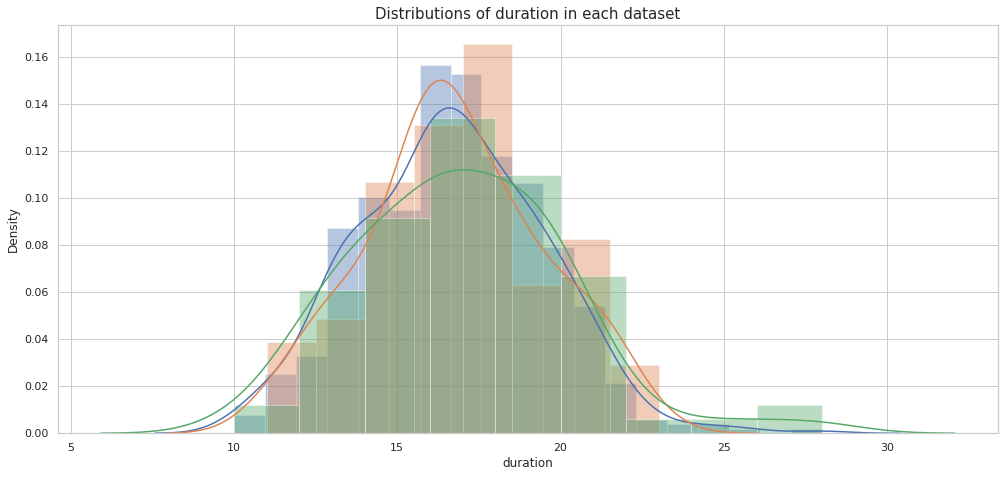

In [127]:
plt.figure(figsize = (15,7))
sns.distplot(X_train[LABEL])
sns.distplot(X_val[LABEL])
sns.distplot(test_data[LABEL])
plt.title("Distributions of duration in each dataset", fontsize = 15)

In [68]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [69]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [70]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 100

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/100
2/2 [==============================] - 14s 1s/step - loss: 274.9195 - output_loss: 274.9195 - output_rmse: 16.5807 - val_loss: 195.6621 - val_output_loss: 195.6621 - val_output_rmse: 13.9879
Epoch 2/100
2/2 [==============================] - 1s 149ms/step - loss: 220.6690 - output_loss: 220.6690 - output_rmse: 14.8549 - val_loss: 176.8247 - val_output_loss: 176.8247 - val_output_rmse: 13.2975
Epoch 3/100
2/2 [==============================] - 1s 155ms/step - loss: 196.4715 - output_loss: 196.4715 - output_rmse: 14.0168 - val_loss: 161.3941 - val_output_loss: 161.3941 - val_output_rmse: 12.7041
Epoch 4/100
2/2 [==============================] - 1s 143ms/step - loss: 180.1811 - output_loss: 180.1811 - output_rmse: 13.4232 - val_loss: 149.9823 - val_output_loss: 149.9823 - val_output_rmse: 12.2467
Epoch 5/100
2/2 [==============================] - 1s 147ms/step - loss: 166.9158 - output_loss: 166.9158 - output_rmse: 12.9196 - val_loss: 141.0006 - val_output_loss: 141.0006 - va

In [71]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 100

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/100
2/2 [==============================] - 11s 1s/step - loss: 260.5865 - output_loss: 260.5865 - output_rmse: 16.1427 - val_loss: 186.4725 - val_output_loss: 186.4725 - val_output_rmse: 13.6555
Epoch 2/100
2/2 [==============================] - 0s 106ms/step - loss: 222.6312 - output_loss: 222.6312 - output_rmse: 14.9208 - val_loss: 180.6697 - val_output_loss: 180.6697 - val_output_rmse: 13.4413
Epoch 3/100
2/2 [==============================] - 0s 109ms/step - loss: 209.5296 - output_loss: 209.5296 - output_rmse: 14.4751 - val_loss: 173.4633 - val_output_loss: 173.4633 - val_output_rmse: 13.1705
Epoch 4/100
2/2 [==============================] - 0s 106ms/step - loss: 199.5325 - output_loss: 199.5325 - output_rmse: 14.1256 - val_loss: 166.2159 - val_output_loss: 166.2159 - val_output_rmse: 12.8925
Epoch 5/100
2/2 [==============================] - 0s 114ms/step - loss: 190.7727 - output_loss: 190.7727 - output_rmse: 13.8120 - val_loss: 159.5486 - val_output_loss: 159.5486 - va

In [72]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 1s/step


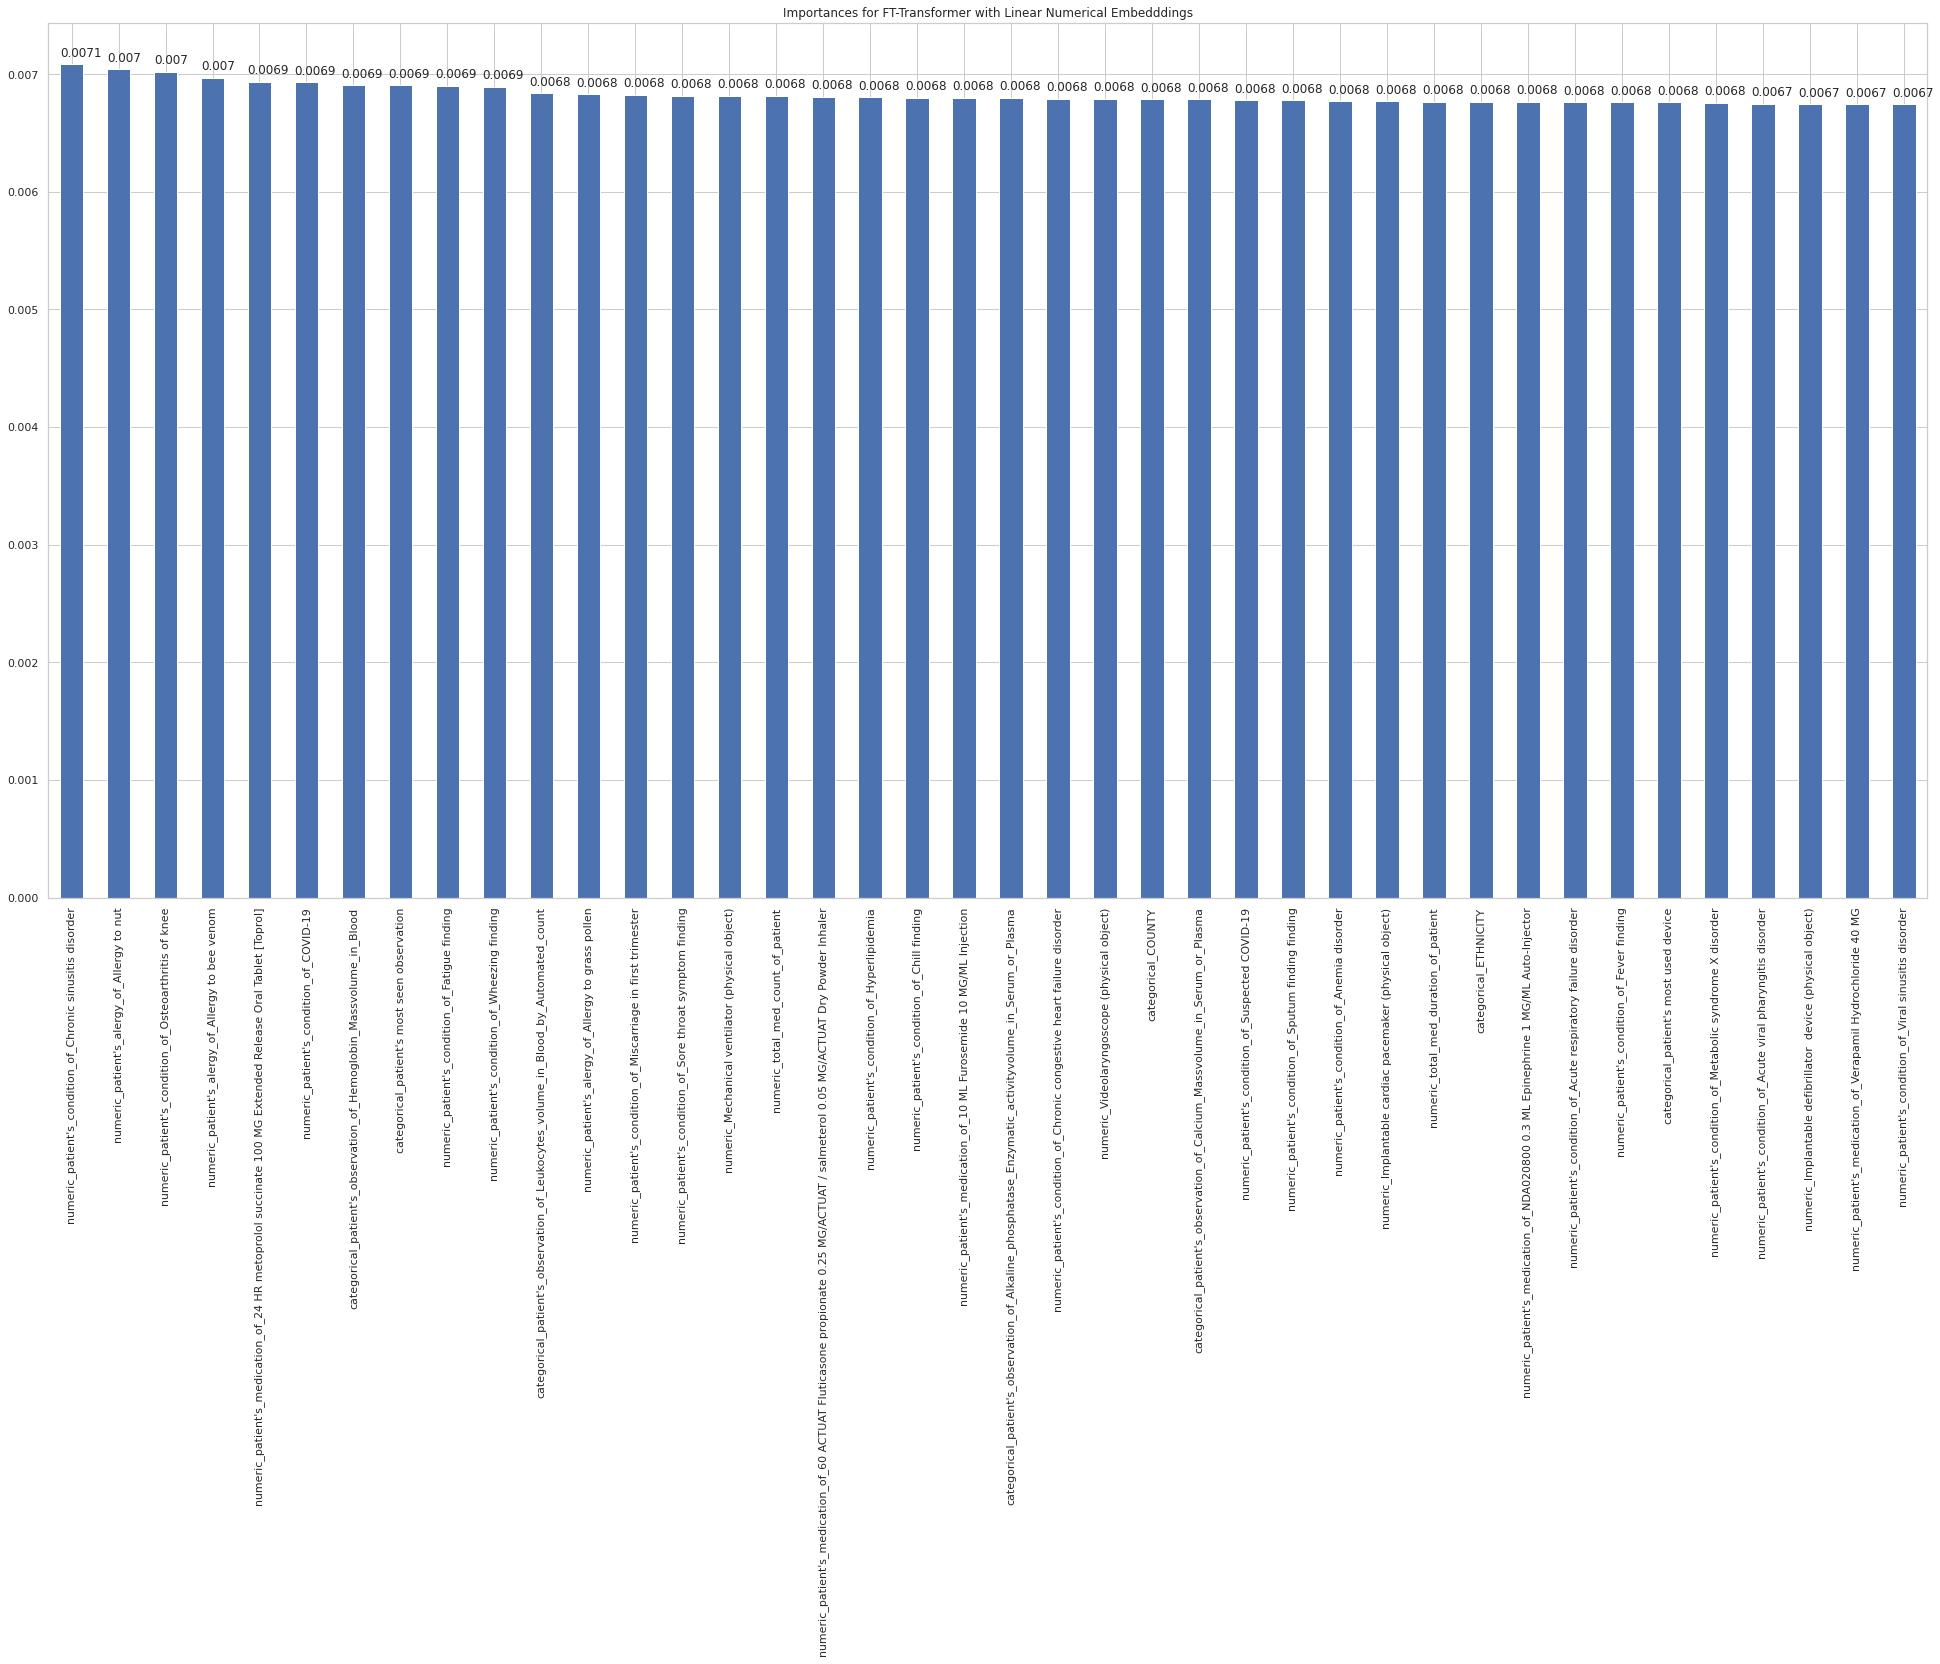

In [73]:
# Utility function
def get_model_importances(importances, title="Importances"):
    imps_sorted = importances.mean().sort_values(ascending=False)
    imps_sorted2 = imps_sorted.copy()[:40]
    
    plt.figure(figsize=(30,15))
    ax = imps_sorted2.plot.bar()
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), 4)), (p.get_x(), p.get_height() * 1.01))
    plt.title(title)
    plt.show()
    
    return imps_sorted

# Model output
linear_importances = linear_test_preds['importances']

# Exclude attention from CLS token to CLS token
linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)

# Plot and store
linear_total_importances = get_model_importances(
    linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)

In [74]:
top20_numeric = []
top20_categoric = []

for column in linear_total_importances.index:
  if "numeric" in column and len(top20_numeric) <= 20:
    top20_numeric.append(column)
  elif "categoric" in column and len(top20_categoric) <= 20:
    top20_categoric.append(column)
  else:
    continue

    

In [75]:
top20_numeric

["numeric_patient's_condition_of_Chronic sinusitis disorder",
 "numeric_patient's_alergy_of_Allergy to nut",
 "numeric_patient's_condition_of_Osteoarthritis of knee",
 "numeric_patient's_alergy_of_Allergy to bee venom",
 "numeric_patient's_medication_of_24 HR metoprolol succinate 100 MG Extended Release Oral Tablet [Toprol]",
 "numeric_patient's_condition_of_COVID-19",
 "numeric_patient's_condition_of_Fatigue finding",
 "numeric_patient's_condition_of_Wheezing finding",
 "numeric_patient's_alergy_of_Allergy to grass pollen",
 "numeric_patient's_condition_of_Miscarriage in first trimester",
 "numeric_patient's_condition_of_Sore throat symptom finding",
 'numeric_Mechanical ventilator (physical object)',
 'numeric_total_med_count_of_patient',
 "numeric_patient's_medication_of_60 ACTUAT Fluticasone propionate 0.25 MG/ACTUAT / salmeterol 0.05 MG/ACTUAT Dry Powder Inhaler",
 "numeric_patient's_condition_of_Hyperlipidemia",
 "numeric_patient's_condition_of_Chill finding",
 "numeric_patient's

In [76]:
top20_categoric

["categorical_patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "categorical_patient's most seen observation",
 "categorical_patient's_observation_of_Leukocytes_volume_in_Blood_by_Automated_count",
 "categorical_patient's_observation_of_Alkaline_phosphatase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 'categorical_COUNTY',
 "categorical_patient's_observation_of_Calcium_Massvolume_in_Serum_or_Plasma",
 'categorical_ETHNICITY',
 "categorical_patient's most used device",
 "categorical_patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "categorical_patient's most seen allergy",
 "categorical_patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "categorical_patient's_observation_of_Hematocrit_Volume_Fraction_of_Blood_by_Automated_count",
 "categorical_patient's_observation_of_Body_temperature",
 "categorical_patient's_observation_of_Monocytes100_leukocytes_in_Blood_by_Automated_count",
 "categorical_patient's_observation_of_Erythrocytes_volume_in_Blood_b

In [77]:
train_data.duration.value_counts()

16.0    108
17.0     99
18.0     75
19.0     68
15.0     63
14.0     60
13.0     55
20.0     48
21.0     38
12.0     22
11.0     16
22.0     16
10.0      4
23.0      4
24.0      2
25.0      2
26.0      1
28.0      1
Name: duration, dtype: int64

In [78]:
FEATURES = list(top20_numeric) + list(top20_categoric)
# Set data types
train_data[top20_categoric] = train_data[top20_categoric].astype(str)
test_data[top20_categoric] = test_data[top20_categoric].astype(str)

train_data[top20_numeric] = train_data[top20_numeric].astype(float)
test_data[top20_numeric] = test_data[top20_numeric].astype(float)

# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2, random_state = 42)

sc = StandardScaler()
X_train.loc[:, top20_numeric] = sc.fit_transform(X_train[top20_numeric])
X_val.loc[:, top20_numeric] = sc.transform(X_val[top20_numeric])
test_data.loc[:, top20_numeric] = sc.transform(test_data[top20_numeric])

train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [79]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = top20_numeric,
    categorical_features = top20_categoric,
    numerical_data = X_train[top20_numeric].values,
    categorical_data = X_train[top20_categoric].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 100

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/100
2/2 [==============================] - 8s 992ms/step - loss: 276.5866 - output_loss: 276.5866 - output_rmse: 16.6309 - val_loss: 203.8017 - val_output_loss: 203.8017 - val_output_rmse: 14.2759
Epoch 2/100
2/2 [==============================] - 0s 77ms/step - loss: 216.7964 - output_loss: 216.7964 - output_rmse: 14.7240 - val_loss: 186.2043 - val_output_loss: 186.2043 - val_output_rmse: 13.6457
Epoch 3/100
2/2 [==============================] - 0s 69ms/step - loss: 191.5950 - output_loss: 191.5950 - output_rmse: 13.8418 - val_loss: 175.3009 - val_output_loss: 175.3009 - val_output_rmse: 13.2401
Epoch 4/100
2/2 [==============================] - 0s 67ms/step - loss: 178.2914 - output_loss: 178.2914 - output_rmse: 13.3526 - val_loss: 168.2146 - val_output_loss: 168.2146 - val_output_rmse: 12.9698
Epoch 5/100
2/2 [==============================] - 0s 70ms/step - loss: 169.7639 - output_loss: 169.7639 - output_rmse: 13.0293 - val_loss: 163.8035 - val_output_loss: 163.8035 - val_

In [80]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = top20_numeric,
    categorical_features = top20_categoric,
    numerical_data = X_train[top20_numeric].values,
    categorical_data = X_train[top20_categoric].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 100

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/100
2/2 [==============================] - 8s 869ms/step - loss: 282.8305 - output_loss: 282.8305 - output_rmse: 16.8176 - val_loss: 257.4008 - val_output_loss: 257.4008 - val_output_rmse: 16.0437
Epoch 2/100
2/2 [==============================] - 0s 65ms/step - loss: 262.2915 - output_loss: 262.2915 - output_rmse: 16.1954 - val_loss: 228.9658 - val_output_loss: 228.9658 - val_output_rmse: 15.1316
Epoch 3/100
2/2 [==============================] - 0s 61ms/step - loss: 239.2530 - output_loss: 239.2530 - output_rmse: 15.4678 - val_loss: 206.1751 - val_output_loss: 206.1751 - val_output_rmse: 14.3588
Epoch 4/100
2/2 [==============================] - 0s 59ms/step - loss: 220.1425 - output_loss: 220.1425 - output_rmse: 14.8372 - val_loss: 190.9883 - val_output_loss: 190.9883 - val_output_rmse: 13.8199
Epoch 5/100
2/2 [==============================] - 0s 62ms/step - loss: 205.3389 - output_loss: 205.3389 - output_rmse: 14.3297 - val_loss: 184.3211 - val_output_loss: 184.3211 - val_

In [81]:
reduced_linear_test_preds = ft_linear_transformer.predict(test_dataset)
reduced_linear_rms = mean_squared_error(test_data[LABEL], reduced_linear_test_preds['output'].ravel(), squared=False)
reduced_linear_mae = mae(test_data[LABEL], reduced_linear_test_preds['output'].ravel())
reduced_linear_r2 = r2_score(test_data[LABEL], reduced_linear_test_preds['output'])

reduced_periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
reduced_periodic_rms = mean_squared_error(test_data[LABEL], reduced_periodic_test_preds['output'].ravel(), squared=False)
reduced_period_mae = mae(test_data[LABEL], reduced_periodic_test_preds['output'].ravel())
reduced_periodic_r2 = r2_score(test_data[LABEL], reduced_periodic_test_preds['output'].ravel())

1/1 [==============================] - 1s 728ms/step


In [82]:
print("With all features, we got RMSE of:", linear_rms)
print("With reducing to top 40 features, we got RMSE of:", reduced_linear_rms)


With all features, we got RMSE of: 3.2995492166631153
With reducing to top 40 features, we got RMSE of: 3.2702910435537635


In [83]:
print("With all features, we got RMSE of:", periodic_rms)
print("With reducing to top 40 features, we got RMSE of:", reduced_periodic_rms)


With all features, we got RMSE of: 3.273774221221495
With reducing to top 40 features, we got RMSE of: 3.308446927582258


In [84]:
CATEGORICAL_FEATURES = top20_categoric
NUMERIC_FEATURES = top20_numeric

In [4]:
#pip install optuna

### Parameter Optimization for Transformer Models

In [86]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-21 19:40:31,276] A new study created in memory with name: no-name-5fbd3faa-3b58-4ef2-a278-4f77b6c40e6b


Epoch 1/150
2/2 [==============================] - 8s 935ms/step - loss: 264.3592 - output_loss: 264.3592 - output_rmse: 16.2591 - val_loss: 156.3905 - val_output_loss: 156.3905 - val_output_rmse: 12.5056
Epoch 2/150
2/2 [==============================] - 0s 71ms/step - loss: 160.4282 - output_loss: 160.4282 - output_rmse: 12.6660 - val_loss: 101.9581 - val_output_loss: 101.9581 - val_output_rmse: 10.0974
Epoch 3/150
2/2 [==============================] - 0s 77ms/step - loss: 109.6352 - output_loss: 109.6352 - output_rmse: 10.4707 - val_loss: 71.7652 - val_output_loss: 71.7652 - val_output_rmse: 8.4714
Epoch 4/150
2/2 [==============================] - 0s 76ms/step - loss: 79.0242 - output_loss: 79.0242 - output_rmse: 8.8896 - val_loss: 55.1277 - val_output_loss: 55.1277 - val_output_rmse: 7.4248
Epoch 5/150
2/2 [==============================] - 0s 67ms/step - loss: 60.2027 - output_loss: 60.2027 - output_rmse: 7.7590 - val_loss: 44.2599 - val_output_loss: 44.2599 - val_output_rmse: 6

1/1 [==============================] - 1s 790ms/step


[I 2023-01-21 19:40:47,786] Trial 0 finished with value: 3.2596301213832053 and parameters: {'numerical_bins': 158, 'embedding_dim': 54, 'depth': 3, 'heads': 4, 'attn_dropout': 0.14649703931647573, 'ff_dropout': 0.16041384221016708}. Best is trial 0 with value: 3.2596301213832053.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 283.0972 - output_loss: 283.0972 - output_rmse: 16.8255 - val_loss: 210.2832 - val_output_loss: 210.2832 - val_output_rmse: 14.5011
Epoch 2/150
2/2 [==============================] - 0s 80ms/step - loss: 239.4516 - output_loss: 239.4516 - output_rmse: 15.4742 - val_loss: 172.9753 - val_output_loss: 172.9753 - val_output_rmse: 13.1520
Epoch 3/150
2/2 [==============================] - 0s 80ms/step - loss: 193.6615 - output_loss: 193.6615 - output_rmse: 13.9162 - val_loss: 148.1670 - val_output_loss: 148.1670 - val_output_rmse: 12.1724
Epoch 4/150
2/2 [==============================] - 0s 85ms/step - loss: 161.8232 - output_loss: 161.8232 - output_rmse: 12.7210 - val_loss: 127.5956 - val_output_loss: 127.5956 - val_output_rmse: 11.2958
Epoch 5/150
2/2 [==============================] - 0s 73ms/step - loss: 139.0150 - output_loss: 139.0150 - output_rmse: 11.7905 - val_loss: 113.4820 - val_output_loss: 113.4820 - val_ou

1/1 [==============================] - 1s 981ms/step


[I 2023-01-21 19:41:11,100] Trial 1 finished with value: 3.26160695194026 and parameters: {'numerical_bins': 24, 'embedding_dim': 49, 'depth': 5, 'heads': 3, 'attn_dropout': 0.4020571286150681, 'ff_dropout': 0.41662851876352525}. Best is trial 0 with value: 3.2596301213832053.


Epoch 1/150
2/2 [==============================] - 6s 821ms/step - loss: 280.4142 - output_loss: 280.4142 - output_rmse: 16.7456 - val_loss: 257.8338 - val_output_loss: 257.8338 - val_output_rmse: 16.0572
Epoch 2/150
2/2 [==============================] - 0s 53ms/step - loss: 263.6579 - output_loss: 263.6579 - output_rmse: 16.2375 - val_loss: 244.3711 - val_output_loss: 244.3711 - val_output_rmse: 15.6324
Epoch 3/150
2/2 [==============================] - 0s 54ms/step - loss: 247.9734 - output_loss: 247.9734 - output_rmse: 15.7472 - val_loss: 235.4059 - val_output_loss: 235.4059 - val_output_rmse: 15.3429
Epoch 4/150
2/2 [==============================] - 0s 56ms/step - loss: 237.9429 - output_loss: 237.9429 - output_rmse: 15.4254 - val_loss: 226.7022 - val_output_loss: 226.7022 - val_output_rmse: 15.0566
Epoch 5/150
2/2 [==============================] - 0s 52ms/step - loss: 229.0453 - output_loss: 229.0453 - output_rmse: 15.1342 - val_loss: 219.4387 - val_output_loss: 219.4387 - val_

[I 2023-01-21 19:41:32,538] Trial 2 finished with value: 3.2682448003759315 and parameters: {'numerical_bins': 36, 'embedding_dim': 23, 'depth': 2, 'heads': 3, 'attn_dropout': 0.2542843917762195, 'ff_dropout': 0.1823078099119383}. Best is trial 0 with value: 3.2596301213832053.


Epoch 1/150
2/2 [==============================] - 8s 1000ms/step - loss: 283.0190 - output_loss: 283.0190 - output_rmse: 16.8232 - val_loss: 208.9329 - val_output_loss: 208.9329 - val_output_rmse: 14.4545
Epoch 2/150
2/2 [==============================] - 0s 80ms/step - loss: 210.9338 - output_loss: 210.9338 - output_rmse: 14.5236 - val_loss: 153.0383 - val_output_loss: 153.0383 - val_output_rmse: 12.3709
Epoch 3/150
2/2 [==============================] - 0s 77ms/step - loss: 163.4134 - output_loss: 163.4134 - output_rmse: 12.7833 - val_loss: 132.7788 - val_output_loss: 132.7788 - val_output_rmse: 11.5230
Epoch 4/150
2/2 [==============================] - 0s 75ms/step - loss: 138.4647 - output_loss: 138.4647 - output_rmse: 11.7671 - val_loss: 120.0734 - val_output_loss: 120.0734 - val_output_rmse: 10.9578
Epoch 5/150
2/2 [==============================] - 0s 73ms/step - loss: 122.4399 - output_loss: 122.4399 - output_rmse: 11.0653 - val_loss: 110.0309 - val_output_loss: 110.0309 - val

[I 2023-01-21 19:41:56,215] Trial 3 finished with value: 3.260974961772507 and parameters: {'numerical_bins': 147, 'embedding_dim': 62, 'depth': 4, 'heads': 6, 'attn_dropout': 0.0753083332339981, 'ff_dropout': 0.20403873423540475}. Best is trial 0 with value: 3.2596301213832053.


Epoch 1/150
2/2 [==============================] - 6s 754ms/step - loss: 267.1087 - output_loss: 267.1087 - output_rmse: 16.3435 - val_loss: 227.3673 - val_output_loss: 227.3673 - val_output_rmse: 15.0787
Epoch 2/150
2/2 [==============================] - 0s 54ms/step - loss: 240.0610 - output_loss: 240.0610 - output_rmse: 15.4939 - val_loss: 203.5222 - val_output_loss: 203.5222 - val_output_rmse: 14.2661
Epoch 3/150
2/2 [==============================] - 0s 54ms/step - loss: 223.5469 - output_loss: 223.5469 - output_rmse: 14.9515 - val_loss: 188.6977 - val_output_loss: 188.6977 - val_output_rmse: 13.7367
Epoch 4/150
2/2 [==============================] - 0s 51ms/step - loss: 210.8055 - output_loss: 210.8055 - output_rmse: 14.5191 - val_loss: 180.0714 - val_output_loss: 180.0714 - val_output_rmse: 13.4191
Epoch 5/150
2/2 [==============================] - 0s 57ms/step - loss: 198.7228 - output_loss: 198.7228 - output_rmse: 14.0969 - val_loss: 174.1836 - val_output_loss: 174.1836 - val_

[I 2023-01-21 19:42:15,286] Trial 4 finished with value: 3.2630591981125208 and parameters: {'numerical_bins': 99, 'embedding_dim': 21, 'depth': 2, 'heads': 8, 'attn_dropout': 0.36931690033008924, 'ff_dropout': 0.31358532917832854}. Best is trial 0 with value: 3.2596301213832053.


Epoch 1/150
2/2 [==============================] - 8s 1s/step - loss: 271.7422 - output_loss: 271.7422 - output_rmse: 16.4846 - val_loss: 128.2619 - val_output_loss: 128.2619 - val_output_rmse: 11.3253
Epoch 2/150
2/2 [==============================] - 0s 85ms/step - loss: 128.9970 - output_loss: 128.9970 - output_rmse: 11.3577 - val_loss: 83.6488 - val_output_loss: 83.6488 - val_output_rmse: 9.1460
Epoch 3/150
2/2 [==============================] - 0s 82ms/step - loss: 85.6561 - output_loss: 85.6561 - output_rmse: 9.2551 - val_loss: 63.2935 - val_output_loss: 63.2935 - val_output_rmse: 7.9557
Epoch 4/150
2/2 [==============================] - 0s 88ms/step - loss: 64.0858 - output_loss: 64.0858 - output_rmse: 8.0054 - val_loss: 54.5969 - val_output_loss: 54.5969 - val_output_rmse: 7.3890
Epoch 5/150
2/2 [==============================] - 0s 80ms/step - loss: 54.6466 - output_loss: 54.6466 - output_rmse: 7.3923 - val_loss: 48.8414 - val_output_loss: 48.8414 - val_output_rmse: 6.9887
Epo

[I 2023-01-21 19:42:37,531] Trial 5 finished with value: 3.26090126708893 and parameters: {'numerical_bins': 149, 'embedding_dim': 74, 'depth': 4, 'heads': 8, 'attn_dropout': 0.31210463144337885, 'ff_dropout': 0.12051600779283045}. Best is trial 0 with value: 3.2596301213832053.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 280.9368 - output_loss: 280.9368 - output_rmse: 16.7612 - val_loss: 281.5904 - val_output_loss: 281.5904 - val_output_rmse: 16.7807
Epoch 2/150
2/2 [==============================] - 0s 70ms/step - loss: 272.9133 - output_loss: 272.9133 - output_rmse: 16.5201 - val_loss: 264.9041 - val_output_loss: 264.9041 - val_output_rmse: 16.2759
Epoch 3/150
2/2 [==============================] - 0s 69ms/step - loss: 262.8545 - output_loss: 262.8545 - output_rmse: 16.2128 - val_loss: 233.8164 - val_output_loss: 233.8164 - val_output_rmse: 15.2911
Epoch 4/150
2/2 [==============================] - 0s 70ms/step - loss: 252.0014 - output_loss: 252.0014 - output_rmse: 15.8746 - val_loss: 217.4369 - val_output_loss: 217.4369 - val_output_rmse: 14.7457
Epoch 5/150
2/2 [==============================] - 0s 78ms/step - loss: 240.3140 - output_loss: 240.3140 - output_rmse: 15.5021 - val_loss: 210.6579 - val_output_loss: 210.6579 - val_out

[I 2023-01-21 19:43:08,742] Trial 6 finished with value: 3.2654674532267562 and parameters: {'numerical_bins': 94, 'embedding_dim': 13, 'depth': 5, 'heads': 3, 'attn_dropout': 0.46528806742982903, 'ff_dropout': 0.4059218371197199}. Best is trial 0 with value: 3.2596301213832053.


Epoch 1/150
2/2 [==============================] - 8s 983ms/step - loss: 283.8197 - output_loss: 283.8197 - output_rmse: 16.8470 - val_loss: 277.8129 - val_output_loss: 277.8129 - val_output_rmse: 16.6677
Epoch 2/150
2/2 [==============================] - 0s 64ms/step - loss: 276.1524 - output_loss: 276.1524 - output_rmse: 16.6178 - val_loss: 248.6531 - val_output_loss: 248.6531 - val_output_rmse: 15.7687
Epoch 3/150
2/2 [==============================] - 0s 65ms/step - loss: 264.3346 - output_loss: 264.3346 - output_rmse: 16.2584 - val_loss: 242.9144 - val_output_loss: 242.9144 - val_output_rmse: 15.5857
Epoch 4/150
2/2 [==============================] - 0s 68ms/step - loss: 254.4986 - output_loss: 254.4986 - output_rmse: 15.9530 - val_loss: 238.2012 - val_output_loss: 238.2012 - val_output_rmse: 15.4338
Epoch 5/150
2/2 [==============================] - 0s 66ms/step - loss: 245.7083 - output_loss: 245.7083 - output_rmse: 15.6751 - val_loss: 233.3031 - val_output_loss: 233.3031 - val_

[I 2023-01-21 19:43:36,673] Trial 7 finished with value: 3.270259430317615 and parameters: {'numerical_bins': 46, 'embedding_dim': 17, 'depth': 4, 'heads': 2, 'attn_dropout': 0.46000474087402177, 'ff_dropout': 0.48338587517422443}. Best is trial 0 with value: 3.2596301213832053.


Epoch 1/150
2/2 [==============================] - 6s 756ms/step - loss: 242.8584 - output_loss: 242.8584 - output_rmse: 15.5839 - val_loss: 113.1375 - val_output_loss: 113.1375 - val_output_rmse: 10.6366
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 115.9872 - output_loss: 115.9872 - output_rmse: 10.7697 - val_loss: 75.9963 - val_output_loss: 75.9963 - val_output_rmse: 8.7176
Epoch 3/150
2/2 [==============================] - 0s 55ms/step - loss: 78.9128 - output_loss: 78.9128 - output_rmse: 8.8833 - val_loss: 55.1798 - val_output_loss: 55.1798 - val_output_rmse: 7.4283
Epoch 4/150
2/2 [==============================] - 0s 54ms/step - loss: 58.2640 - output_loss: 58.2640 - output_rmse: 7.6331 - val_loss: 43.2261 - val_output_loss: 43.2261 - val_output_rmse: 6.5747
Epoch 5/150
2/2 [==============================] - 0s 54ms/step - loss: 45.8467 - output_loss: 45.8467 - output_rmse: 6.7710 - val_loss: 36.2973 - val_output_loss: 36.2973 - val_output_rmse: 6.0247


[I 2023-01-21 19:43:55,353] Trial 8 finished with value: 3.2558977715293302 and parameters: {'numerical_bins': 104, 'embedding_dim': 89, 'depth': 2, 'heads': 2, 'attn_dropout': 0.03600050380844649, 'ff_dropout': 0.1101329956670366}. Best is trial 8 with value: 3.2558977715293302.


Epoch 1/150
2/2 [==============================] - 7s 876ms/step - loss: 256.5775 - output_loss: 256.5775 - output_rmse: 16.0180 - val_loss: 144.7673 - val_output_loss: 144.7673 - val_output_rmse: 12.0319
Epoch 2/150
2/2 [==============================] - 0s 68ms/step - loss: 164.5253 - output_loss: 164.5253 - output_rmse: 12.8267 - val_loss: 94.0342 - val_output_loss: 94.0342 - val_output_rmse: 9.6971
Epoch 3/150
2/2 [==============================] - 0s 63ms/step - loss: 115.9975 - output_loss: 115.9975 - output_rmse: 10.7702 - val_loss: 66.2570 - val_output_loss: 66.2570 - val_output_rmse: 8.1398
Epoch 4/150
2/2 [==============================] - 0s 65ms/step - loss: 84.9490 - output_loss: 84.9490 - output_rmse: 9.2168 - val_loss: 50.0881 - val_output_loss: 50.0881 - val_output_rmse: 7.0773
Epoch 5/150
2/2 [==============================] - 0s 65ms/step - loss: 63.5944 - output_loss: 63.5944 - output_rmse: 7.9746 - val_loss: 41.0983 - val_output_loss: 41.0983 - val_output_rmse: 6.41

[I 2023-01-21 19:44:21,234] Trial 9 finished with value: 3.281721511909074 and parameters: {'numerical_bins': 106, 'embedding_dim': 91, 'depth': 3, 'heads': 2, 'attn_dropout': 0.14462255021727372, 'ff_dropout': 0.37027093604167577}. Best is trial 8 with value: 3.2558977715293302.


Number of finished trials: 10
Best trial: {'numerical_bins': 104, 'embedding_dim': 89, 'depth': 2, 'heads': 2, 'attn_dropout': 0.03600050380844649, 'ff_dropout': 0.1101329956670366}


In [87]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=20,
    embedding_dim=10,
    depth=2,
    heads=4,
    attn_dropout= 0.01,
    ff_dropout= 0.01,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 6s 733ms/step - loss: 285.1668 - output_loss: 285.1668 - output_rmse: 16.8869 - val_loss: 290.6335 - val_output_loss: 290.6335 - val_output_rmse: 17.0480
Epoch 2/250
2/2 [==============================] - 0s 49ms/step - loss: 283.4284 - output_loss: 283.4284 - output_rmse: 16.8353 - val_loss: 285.5905 - val_output_loss: 285.5905 - val_output_rmse: 16.8994
Epoch 3/250
2/2 [==============================] - 0s 55ms/step - loss: 279.2162 - output_loss: 279.2162 - output_rmse: 16.7098 - val_loss: 280.7059 - val_output_loss: 280.7059 - val_output_rmse: 16.7543
Epoch 4/250
2/2 [==============================] - 0s 52ms/step - loss: 273.9891 - output_loss: 273.9891 - output_rmse: 16.5526 - val_loss: 272.9943 - val_output_loss: 272.9943 - val_output_rmse: 16.5225
Epoch 5/250
2/2 [==============================] - 0s 55ms/step - loss: 265.8984 - output_loss: 265.8984 - output_rmse: 16.3064 - val_loss: 263.9962 - val_output_loss: 263.9962 - val_

In [88]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 1s 620ms/step


### Periodic Encoding FT Transformer Model Graphs

In [89]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

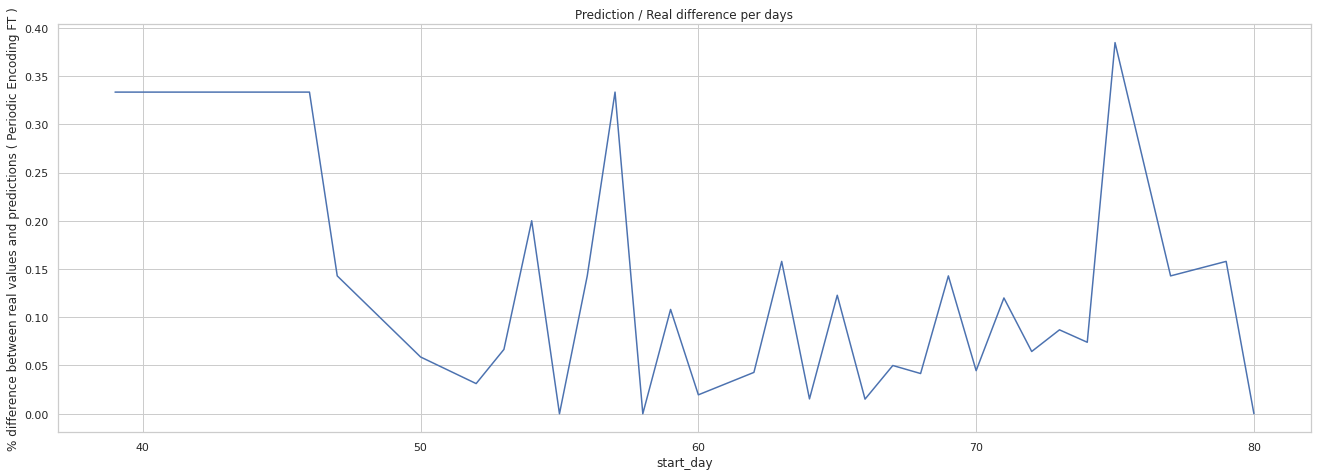

In [90]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

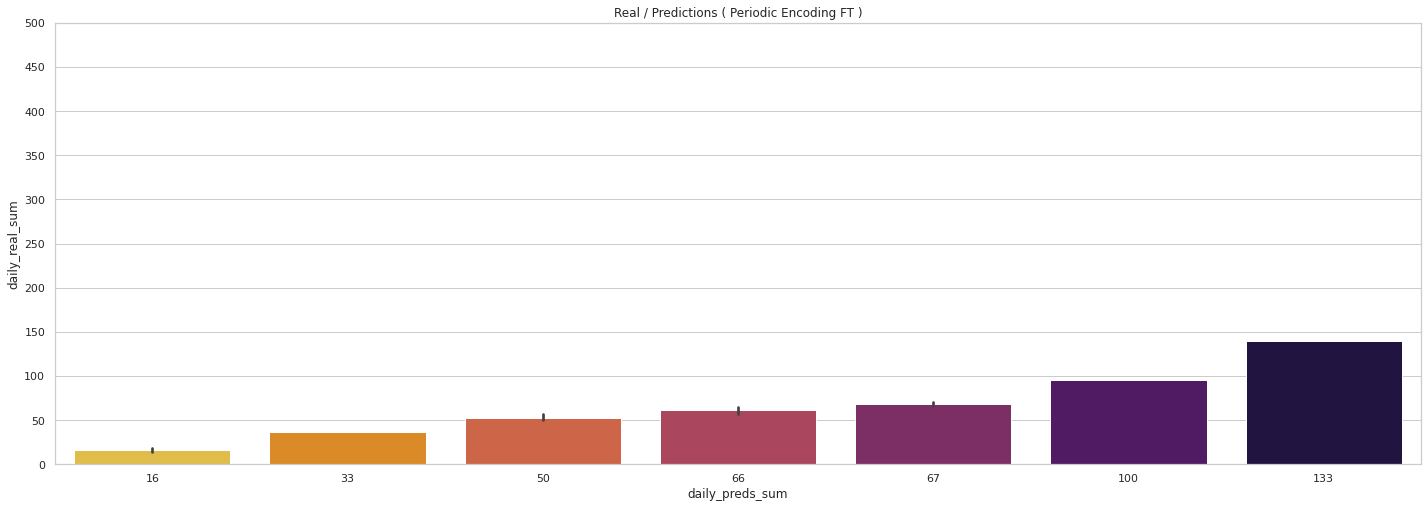

In [91]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

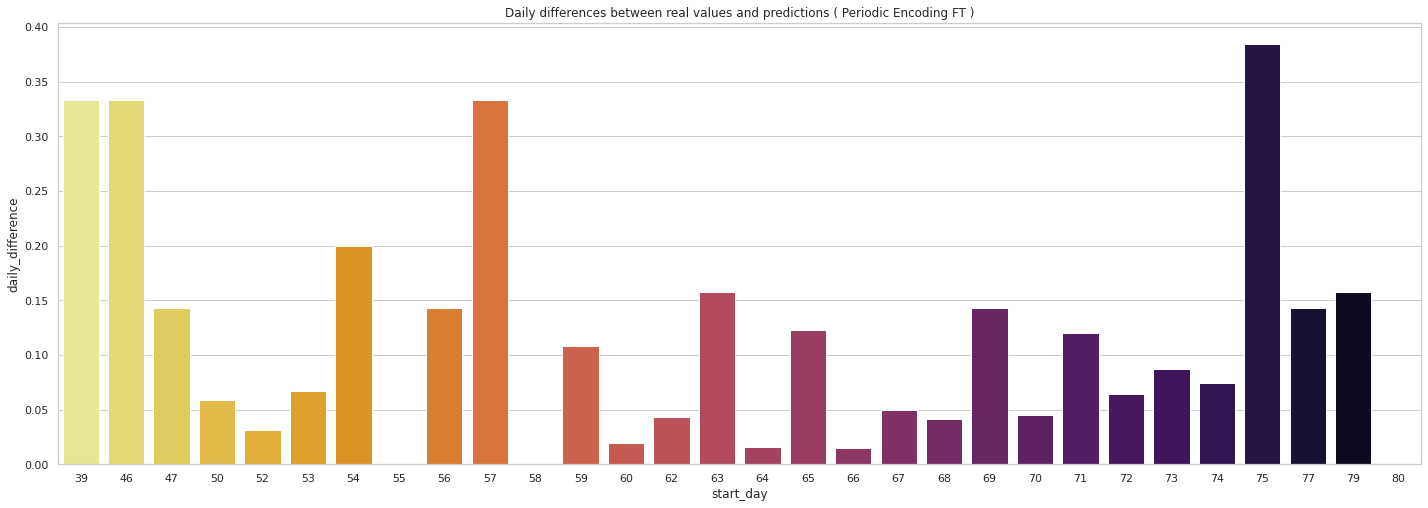

In [92]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [93]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-21 19:44:50,278] A new study created in memory with name: no-name-3c302315-2234-43e1-a682-29302fc24e4d


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 273.0610 - output_loss: 273.0610 - output_rmse: 16.5246 - val_loss: 159.6929 - val_output_loss: 159.6929 - val_output_rmse: 12.6370
Epoch 2/150
2/2 [==============================] - 0s 85ms/step - loss: 169.5170 - output_loss: 169.5170 - output_rmse: 13.0199 - val_loss: 109.4911 - val_output_loss: 109.4911 - val_output_rmse: 10.4638
Epoch 3/150
2/2 [==============================] - 0s 85ms/step - loss: 118.7231 - output_loss: 118.7231 - output_rmse: 10.8960 - val_loss: 87.7796 - val_output_loss: 87.7796 - val_output_rmse: 9.3691
Epoch 4/150
2/2 [==============================] - 0s 84ms/step - loss: 94.4417 - output_loss: 94.4417 - output_rmse: 9.7181 - val_loss: 77.8252 - val_output_loss: 77.8252 - val_output_rmse: 8.8219
Epoch 5/150
2/2 [==============================] - 0s 87ms/step - loss: 81.4152 - output_loss: 81.4152 - output_rmse: 9.0230 - val_loss: 71.4488 - val_output_loss: 71.4488 - val_output_rmse: 8.4

[I 2023-01-21 19:45:15,469] Trial 0 finished with value: 3.2607301075457498 and parameters: {'numerical_bins': 134, 'embedding_dim': 47, 'depth': 5, 'heads': 7, 'attn_dropout': 0.42498959372039624, 'ff_dropout': 0.22905667713159622}. Best is trial 0 with value: 3.2607301075457498.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 279.3571 - output_loss: 279.3571 - output_rmse: 16.7140 - val_loss: 152.0658 - val_output_loss: 152.0658 - val_output_rmse: 12.3315
Epoch 2/150
2/2 [==============================] - 0s 87ms/step - loss: 176.4073 - output_loss: 176.4073 - output_rmse: 13.2818 - val_loss: 99.8397 - val_output_loss: 99.8397 - val_output_rmse: 9.9920
Epoch 3/150
2/2 [==============================] - 0s 86ms/step - loss: 115.3747 - output_loss: 115.3747 - output_rmse: 10.7413 - val_loss: 80.1172 - val_output_loss: 80.1172 - val_output_rmse: 8.9508
Epoch 4/150
2/2 [==============================] - 0s 88ms/step - loss: 86.7885 - output_loss: 86.7885 - output_rmse: 9.3160 - val_loss: 68.1583 - val_output_loss: 68.1583 - val_output_rmse: 8.2558
Epoch 5/150
2/2 [==============================] - 0s 83ms/step - loss: 72.4631 - output_loss: 72.4631 - output_rmse: 8.5125 - val_loss: 62.4624 - val_output_loss: 62.4624 - val_output_rmse: 7.9033

[I 2023-01-21 19:45:42,727] Trial 1 finished with value: 3.2607785044690134 and parameters: {'numerical_bins': 64, 'embedding_dim': 63, 'depth': 5, 'heads': 7, 'attn_dropout': 0.13204965575399774, 'ff_dropout': 0.4323319000951933}. Best is trial 0 with value: 3.2607301075457498.


Epoch 1/150
2/2 [==============================] - 5s 599ms/step - loss: 285.1730 - output_loss: 285.1730 - output_rmse: 16.8871 - val_loss: 260.9114 - val_output_loss: 260.9114 - val_output_rmse: 16.1528
Epoch 2/150
2/2 [==============================] - 0s 47ms/step - loss: 259.7148 - output_loss: 259.7148 - output_rmse: 16.1157 - val_loss: 237.9930 - val_output_loss: 237.9930 - val_output_rmse: 15.4270
Epoch 3/150
2/2 [==============================] - 0s 44ms/step - loss: 238.2814 - output_loss: 238.2814 - output_rmse: 15.4364 - val_loss: 228.0211 - val_output_loss: 228.0211 - val_output_rmse: 15.1004
Epoch 4/150
2/2 [==============================] - 0s 46ms/step - loss: 227.1252 - output_loss: 227.1252 - output_rmse: 15.0707 - val_loss: 221.4137 - val_output_loss: 221.4137 - val_output_rmse: 14.8800
Epoch 5/150
2/2 [==============================] - 0s 48ms/step - loss: 220.4315 - output_loss: 220.4315 - output_rmse: 14.8469 - val_loss: 215.7538 - val_output_loss: 215.7538 - val_

[I 2023-01-21 19:45:59,203] Trial 2 finished with value: 3.2623035220048036 and parameters: {'numerical_bins': 188, 'embedding_dim': 42, 'depth': 1, 'heads': 5, 'attn_dropout': 0.2067275577157318, 'ff_dropout': 0.15173919394311286}. Best is trial 0 with value: 3.2607301075457498.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 260.6227 - output_loss: 260.6227 - output_rmse: 16.1438 - val_loss: 216.2571 - val_output_loss: 216.2571 - val_output_rmse: 14.7057
Epoch 2/150
2/2 [==============================] - 0s 79ms/step - loss: 230.5419 - output_loss: 230.5419 - output_rmse: 15.1836 - val_loss: 201.7000 - val_output_loss: 201.7000 - val_output_rmse: 14.2021
Epoch 3/150
2/2 [==============================] - 0s 78ms/step - loss: 210.8676 - output_loss: 210.8676 - output_rmse: 14.5213 - val_loss: 189.6676 - val_output_loss: 189.6676 - val_output_rmse: 13.7720
Epoch 4/150
2/2 [==============================] - 0s 81ms/step - loss: 195.4319 - output_loss: 195.4319 - output_rmse: 13.9797 - val_loss: 178.9844 - val_output_loss: 178.9844 - val_output_rmse: 13.3785
Epoch 5/150
2/2 [==============================] - 0s 76ms/step - loss: 182.9220 - output_loss: 182.9220 - output_rmse: 13.5249 - val_loss: 170.4402 - val_output_loss: 170.4402 - val_out

[I 2023-01-21 19:46:28,249] Trial 3 finished with value: 3.2670702362664343 and parameters: {'numerical_bins': 75, 'embedding_dim': 29, 'depth': 5, 'heads': 7, 'attn_dropout': 0.15655261716026653, 'ff_dropout': 0.4915579066763687}. Best is trial 0 with value: 3.2607301075457498.


Epoch 1/150
2/2 [==============================] - 7s 853ms/step - loss: 274.4801 - output_loss: 274.4801 - output_rmse: 16.5674 - val_loss: 257.0710 - val_output_loss: 257.0710 - val_output_rmse: 16.0334
Epoch 2/150
2/2 [==============================] - 0s 58ms/step - loss: 262.4840 - output_loss: 262.4840 - output_rmse: 16.2014 - val_loss: 242.8610 - val_output_loss: 242.8610 - val_output_rmse: 15.5840
Epoch 3/150
2/2 [==============================] - 0s 61ms/step - loss: 252.9872 - output_loss: 252.9872 - output_rmse: 15.9056 - val_loss: 231.9239 - val_output_loss: 231.9239 - val_output_rmse: 15.2290
Epoch 4/150
2/2 [==============================] - 0s 60ms/step - loss: 242.6267 - output_loss: 242.6267 - output_rmse: 15.5765 - val_loss: 224.4831 - val_output_loss: 224.4831 - val_output_rmse: 14.9828
Epoch 5/150
2/2 [==============================] - 0s 63ms/step - loss: 234.2501 - output_loss: 234.2501 - output_rmse: 15.3052 - val_loss: 219.8576 - val_output_loss: 219.8576 - val_

[I 2023-01-21 19:46:54,838] Trial 4 finished with value: 3.2773718546856285 and parameters: {'numerical_bins': 61, 'embedding_dim': 10, 'depth': 3, 'heads': 7, 'attn_dropout': 0.30322767650924914, 'ff_dropout': 0.35232426561965147}. Best is trial 0 with value: 3.2607301075457498.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 277.8423 - output_loss: 277.8423 - output_rmse: 16.6686 - val_loss: 88.6039 - val_output_loss: 88.6039 - val_output_rmse: 9.4130
Epoch 2/150
2/2 [==============================] - 0s 98ms/step - loss: 105.4982 - output_loss: 105.4982 - output_rmse: 10.2712 - val_loss: 49.2392 - val_output_loss: 49.2392 - val_output_rmse: 7.0171
Epoch 3/150
2/2 [==============================] - 0s 103ms/step - loss: 55.1928 - output_loss: 55.1928 - output_rmse: 7.4292 - val_loss: 39.0759 - val_output_loss: 39.0759 - val_output_rmse: 6.2511
Epoch 4/150
2/2 [==============================] - 0s 96ms/step - loss: 40.8806 - output_loss: 40.8806 - output_rmse: 6.3938 - val_loss: 34.1903 - val_output_loss: 34.1903 - val_output_rmse: 5.8473
Epoch 5/150
2/2 [==============================] - 0s 99ms/step - loss: 34.3693 - output_loss: 34.3693 - output_rmse: 5.8625 - val_loss: 30.3424 - val_output_loss: 30.3424 - val_output_rmse: 5.5084
Epoc

[I 2023-01-21 19:47:19,463] Trial 5 finished with value: 3.2609112545467123 and parameters: {'numerical_bins': 35, 'embedding_dim': 92, 'depth': 5, 'heads': 8, 'attn_dropout': 0.40214331167932676, 'ff_dropout': 0.3132213407246646}. Best is trial 0 with value: 3.2607301075457498.


Epoch 1/150
2/2 [==============================] - 8s 996ms/step - loss: 270.6280 - output_loss: 270.6280 - output_rmse: 16.4508 - val_loss: 164.8810 - val_output_loss: 164.8810 - val_output_rmse: 12.8406
Epoch 2/150
2/2 [==============================] - 0s 70ms/step - loss: 167.3932 - output_loss: 167.3932 - output_rmse: 12.9381 - val_loss: 132.7127 - val_output_loss: 132.7127 - val_output_rmse: 11.5201
Epoch 3/150
2/2 [==============================] - 0s 71ms/step - loss: 134.3059 - output_loss: 134.3059 - output_rmse: 11.5890 - val_loss: 116.6068 - val_output_loss: 116.6068 - val_output_rmse: 10.7985
Epoch 4/150
2/2 [==============================] - 0s 67ms/step - loss: 116.8859 - output_loss: 116.8859 - output_rmse: 10.8114 - val_loss: 107.0383 - val_output_loss: 107.0383 - val_output_rmse: 10.3459
Epoch 5/150
2/2 [==============================] - 0s 70ms/step - loss: 106.3590 - output_loss: 106.3590 - output_rmse: 10.3130 - val_loss: 96.7833 - val_output_loss: 96.7833 - val_ou

[I 2023-01-21 19:47:39,856] Trial 6 finished with value: 3.2609251903088987 and parameters: {'numerical_bins': 146, 'embedding_dim': 40, 'depth': 4, 'heads': 2, 'attn_dropout': 0.1918938709077107, 'ff_dropout': 0.08407382525907486}. Best is trial 0 with value: 3.2607301075457498.


Epoch 1/150
2/2 [==============================] - 11s 1s/step - loss: 274.6704 - output_loss: 274.6704 - output_rmse: 16.5732 - val_loss: 123.7246 - val_output_loss: 123.7246 - val_output_rmse: 11.1232
Epoch 2/150
2/2 [==============================] - 0s 95ms/step - loss: 148.2603 - output_loss: 148.2603 - output_rmse: 12.1762 - val_loss: 91.4237 - val_output_loss: 91.4237 - val_output_rmse: 9.5616
Epoch 3/150
2/2 [==============================] - 0s 90ms/step - loss: 101.9866 - output_loss: 101.9866 - output_rmse: 10.0988 - val_loss: 79.2979 - val_output_loss: 79.2979 - val_output_rmse: 8.9049
Epoch 4/150
2/2 [==============================] - 0s 92ms/step - loss: 83.8319 - output_loss: 83.8319 - output_rmse: 9.1560 - val_loss: 72.1459 - val_output_loss: 72.1459 - val_output_rmse: 8.4939
Epoch 5/150
2/2 [==============================] - 0s 91ms/step - loss: 73.8381 - output_loss: 73.8381 - output_rmse: 8.5929 - val_loss: 65.5387 - val_output_loss: 65.5387 - val_output_rmse: 8.0956

[I 2023-01-21 19:48:07,229] Trial 7 finished with value: 3.260881697500847 and parameters: {'numerical_bins': 141, 'embedding_dim': 58, 'depth': 6, 'heads': 6, 'attn_dropout': 0.3458200258532454, 'ff_dropout': 0.35046195330099444}. Best is trial 0 with value: 3.2607301075457498.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 279.3814 - output_loss: 279.3814 - output_rmse: 16.7147 - val_loss: 207.4133 - val_output_loss: 207.4133 - val_output_rmse: 14.4018
Epoch 2/150
2/2 [==============================] - 0s 76ms/step - loss: 229.0206 - output_loss: 229.0206 - output_rmse: 15.1334 - val_loss: 182.8775 - val_output_loss: 182.8775 - val_output_rmse: 13.5232
Epoch 3/150
2/2 [==============================] - 0s 78ms/step - loss: 199.7715 - output_loss: 199.7715 - output_rmse: 14.1341 - val_loss: 174.7584 - val_output_loss: 174.7584 - val_output_rmse: 13.2196
Epoch 4/150
2/2 [==============================] - 0s 77ms/step - loss: 184.3865 - output_loss: 184.3865 - output_rmse: 13.5789 - val_loss: 168.7123 - val_output_loss: 168.7123 - val_output_rmse: 12.9889
Epoch 5/150
2/2 [==============================] - 0s 75ms/step - loss: 173.9742 - output_loss: 173.9742 - output_rmse: 13.1899 - val_loss: 161.6817 - val_output_loss: 161.6817 - val_ou

[I 2023-01-21 19:48:33,460] Trial 8 finished with value: 3.266548603170559 and parameters: {'numerical_bins': 154, 'embedding_dim': 36, 'depth': 5, 'heads': 3, 'attn_dropout': 0.2506887664726638, 'ff_dropout': 0.3724408700511654}. Best is trial 0 with value: 3.2607301075457498.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 273.2682 - output_loss: 273.2682 - output_rmse: 16.5308 - val_loss: 122.2204 - val_output_loss: 122.2204 - val_output_rmse: 11.0553
Epoch 2/150
2/2 [==============================] - 0s 82ms/step - loss: 154.9949 - output_loss: 154.9949 - output_rmse: 12.4497 - val_loss: 72.3171 - val_output_loss: 72.3171 - val_output_rmse: 8.5039
Epoch 3/150
2/2 [==============================] - 0s 77ms/step - loss: 93.3904 - output_loss: 93.3904 - output_rmse: 9.6639 - val_loss: 55.6642 - val_output_loss: 55.6642 - val_output_rmse: 7.4608
Epoch 4/150
2/2 [==============================] - 0s 86ms/step - loss: 65.3969 - output_loss: 65.3969 - output_rmse: 8.0868 - val_loss: 45.2087 - val_output_loss: 45.2087 - val_output_rmse: 6.7237
Epoch 5/150
2/2 [==============================] - 0s 90ms/step - loss: 49.9773 - output_loss: 49.9773 - output_rmse: 7.0695 - val_loss: 37.9641 - val_output_loss: 37.9641 - val_output_rmse: 6.1615
Ep

[I 2023-01-21 19:48:52,371] Trial 9 finished with value: 3.260468851974697 and parameters: {'numerical_bins': 58, 'embedding_dim': 78, 'depth': 5, 'heads': 3, 'attn_dropout': 0.49380074592464546, 'ff_dropout': 0.39001284308128575}. Best is trial 9 with value: 3.260468851974697.


Epoch 1/150
2/2 [==============================] - 6s 739ms/step - loss: 255.1076 - output_loss: 255.1076 - output_rmse: 15.9721 - val_loss: 115.3971 - val_output_loss: 115.3971 - val_output_rmse: 10.7423
Epoch 2/150
2/2 [==============================] - 0s 59ms/step - loss: 112.6290 - output_loss: 112.6290 - output_rmse: 10.6127 - val_loss: 70.9756 - val_output_loss: 70.9756 - val_output_rmse: 8.4247
Epoch 3/150
2/2 [==============================] - 0s 61ms/step - loss: 68.8328 - output_loss: 68.8328 - output_rmse: 8.2966 - val_loss: 45.7214 - val_output_loss: 45.7214 - val_output_rmse: 6.7618
Epoch 4/150
2/2 [==============================] - 0s 57ms/step - loss: 44.2531 - output_loss: 44.2531 - output_rmse: 6.6523 - val_loss: 34.3516 - val_output_loss: 34.3516 - val_output_rmse: 5.8610
Epoch 5/150
2/2 [==============================] - 0s 57ms/step - loss: 32.9491 - output_loss: 32.9491 - output_rmse: 5.7401 - val_loss: 26.8002 - val_output_loss: 26.8002 - val_output_rmse: 5.1769


[I 2023-01-21 19:49:13,603] Trial 10 finished with value: 3.259637784024137 and parameters: {'numerical_bins': 100, 'embedding_dim': 88, 'depth': 2, 'heads': 4, 'attn_dropout': 0.4956150625096905, 'ff_dropout': 0.008889290856173904}. Best is trial 10 with value: 3.259637784024137.


Epoch 1/150
2/2 [==============================] - 6s 730ms/step - loss: 239.8411 - output_loss: 239.8411 - output_rmse: 15.4868 - val_loss: 103.0129 - val_output_loss: 103.0129 - val_output_rmse: 10.1495
Epoch 2/150
2/2 [==============================] - 0s 62ms/step - loss: 99.9254 - output_loss: 99.9254 - output_rmse: 9.9963 - val_loss: 58.3907 - val_output_loss: 58.3907 - val_output_rmse: 7.6414
Epoch 3/150
2/2 [==============================] - 0s 56ms/step - loss: 56.1368 - output_loss: 56.1368 - output_rmse: 7.4924 - val_loss: 38.6183 - val_output_loss: 38.6183 - val_output_rmse: 6.2144
Epoch 4/150
2/2 [==============================] - 0s 58ms/step - loss: 36.9749 - output_loss: 36.9749 - output_rmse: 6.0807 - val_loss: 27.7755 - val_output_loss: 27.7755 - val_output_rmse: 5.2703
Epoch 5/150
2/2 [==============================] - 0s 53ms/step - loss: 26.5627 - output_loss: 26.5627 - output_rmse: 5.1539 - val_loss: 21.7648 - val_output_loss: 21.7648 - val_output_rmse: 4.6653
Epo

[I 2023-01-21 19:49:30,162] Trial 11 finished with value: 3.2600038949443046 and parameters: {'numerical_bins': 98, 'embedding_dim': 88, 'depth': 2, 'heads': 4, 'attn_dropout': 0.4986322012283937, 'ff_dropout': 0.009005241831600562}. Best is trial 10 with value: 3.259637784024137.


Epoch 1/150
2/2 [==============================] - 6s 740ms/step - loss: 273.3475 - output_loss: 273.3475 - output_rmse: 16.5332 - val_loss: 164.2129 - val_output_loss: 164.2129 - val_output_rmse: 12.8146
Epoch 2/150
2/2 [==============================] - 0s 58ms/step - loss: 159.9654 - output_loss: 159.9654 - output_rmse: 12.6477 - val_loss: 126.8174 - val_output_loss: 126.8174 - val_output_rmse: 11.2613
Epoch 3/150
2/2 [==============================] - 0s 58ms/step - loss: 123.9131 - output_loss: 123.9131 - output_rmse: 11.1316 - val_loss: 104.4853 - val_output_loss: 104.4853 - val_output_rmse: 10.2218
Epoch 4/150
2/2 [==============================] - 0s 60ms/step - loss: 101.3512 - output_loss: 101.3512 - output_rmse: 10.0673 - val_loss: 88.4185 - val_output_loss: 88.4185 - val_output_rmse: 9.4031
Epoch 5/150
2/2 [==============================] - 0s 61ms/step - loss: 85.8287 - output_loss: 85.8287 - output_rmse: 9.2644 - val_loss: 77.5886 - val_output_loss: 77.5886 - val_output_r

[I 2023-01-21 19:49:44,372] Trial 12 finished with value: 3.2608980873843185 and parameters: {'numerical_bins': 101, 'embedding_dim': 100, 'depth': 2, 'heads': 4, 'attn_dropout': 0.4964934318939716, 'ff_dropout': 0.009956387351510153}. Best is trial 10 with value: 3.259637784024137.


Epoch 1/150
2/2 [==============================] - 5s 609ms/step - loss: 278.8776 - output_loss: 278.8776 - output_rmse: 16.6996 - val_loss: 137.1515 - val_output_loss: 137.1515 - val_output_rmse: 11.7112
Epoch 2/150
2/2 [==============================] - 0s 48ms/step - loss: 134.6733 - output_loss: 134.6733 - output_rmse: 11.6049 - val_loss: 89.9030 - val_output_loss: 89.9030 - val_output_rmse: 9.4817
Epoch 3/150
2/2 [==============================] - 0s 49ms/step - loss: 89.0867 - output_loss: 89.0867 - output_rmse: 9.4386 - val_loss: 60.0757 - val_output_loss: 60.0757 - val_output_rmse: 7.7508
Epoch 4/150
2/2 [==============================] - 0s 50ms/step - loss: 61.3899 - output_loss: 61.3899 - output_rmse: 7.8352 - val_loss: 43.2291 - val_output_loss: 43.2291 - val_output_rmse: 6.5749
Epoch 5/150
2/2 [==============================] - 0s 49ms/step - loss: 45.2175 - output_loss: 45.2175 - output_rmse: 6.7244 - val_loss: 31.9880 - val_output_loss: 31.9880 - val_output_rmse: 5.6558


[I 2023-01-21 19:49:55,716] Trial 13 finished with value: 3.254131807587867 and parameters: {'numerical_bins': 106, 'embedding_dim': 78, 'depth': 1, 'heads': 4, 'attn_dropout': 0.05238415562951704, 'ff_dropout': 0.04817618738931744}. Best is trial 13 with value: 3.254131807587867.


Epoch 1/150
2/2 [==============================] - 5s 630ms/step - loss: 273.1704 - output_loss: 273.1704 - output_rmse: 16.5279 - val_loss: 149.7465 - val_output_loss: 149.7465 - val_output_rmse: 12.2371
Epoch 2/150
2/2 [==============================] - 0s 48ms/step - loss: 151.6242 - output_loss: 151.6242 - output_rmse: 12.3136 - val_loss: 105.6426 - val_output_loss: 105.6426 - val_output_rmse: 10.2783
Epoch 3/150
2/2 [==============================] - 0s 48ms/step - loss: 111.9703 - output_loss: 111.9703 - output_rmse: 10.5816 - val_loss: 78.3221 - val_output_loss: 78.3221 - val_output_rmse: 8.8500
Epoch 4/150
2/2 [==============================] - 0s 49ms/step - loss: 86.6037 - output_loss: 86.6037 - output_rmse: 9.3061 - val_loss: 58.4577 - val_output_loss: 58.4577 - val_output_rmse: 7.6458
Epoch 5/150
2/2 [==============================] - 0s 49ms/step - loss: 66.3568 - output_loss: 66.3568 - output_rmse: 8.1460 - val_loss: 42.9398 - val_output_loss: 42.9398 - val_output_rmse: 6

[I 2023-01-21 19:50:06,993] Trial 14 finished with value: 3.2696361112304184 and parameters: {'numerical_bins': 115, 'embedding_dim': 75, 'depth': 1, 'heads': 5, 'attn_dropout': 0.021716683066465292, 'ff_dropout': 0.1363169529501956}. Best is trial 13 with value: 3.254131807587867.


Number of finished trials: 15
Best trial: {'numerical_bins': 106, 'embedding_dim': 78, 'depth': 1, 'heads': 4, 'attn_dropout': 0.05238415562951704, 'ff_dropout': 0.04817618738931744}


In [94]:
study.best_trial.params

{'numerical_bins': 106,
 'embedding_dim': 78,
 'depth': 1,
 'heads': 4,
 'attn_dropout': 0.05238415562951704,
 'ff_dropout': 0.04817618738931744}

In [95]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=175,
    embedding_dim=63,
    depth=6,
    heads=5,
    attn_dropout= 0.4625548761420795,
    ff_dropout= 0.03666783269628182,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 11s 1s/step - loss: 272.1021 - output_loss: 272.1021 - output_rmse: 16.4955 - val_loss: 83.9090 - val_output_loss: 83.9090 - val_output_rmse: 9.1602
Epoch 2/250
2/2 [==============================] - 0s 93ms/step - loss: 82.7065 - output_loss: 82.7065 - output_rmse: 9.0943 - val_loss: 40.7857 - val_output_loss: 40.7857 - val_output_rmse: 6.3864
Epoch 3/250
2/2 [==============================] - 0s 92ms/step - loss: 40.5189 - output_loss: 40.5189 - output_rmse: 6.3654 - val_loss: 29.0236 - val_output_loss: 29.0236 - val_output_rmse: 5.3874
Epoch 4/250
2/2 [==============================] - 0s 95ms/step - loss: 28.4361 - output_loss: 28.4361 - output_rmse: 5.3326 - val_loss: 21.4228 - val_output_loss: 21.4228 - val_output_rmse: 4.6285
Epoch 5/250
2/2 [==============================] - 0s 92ms/step - loss: 20.9811 - output_loss: 20.9811 - output_rmse: 4.5805 - val_loss: 17.1038 - val_output_loss: 17.1038 - val_output_rmse: 4.1357
Epoch 6/

In [96]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 1s/step


In [97]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 21ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

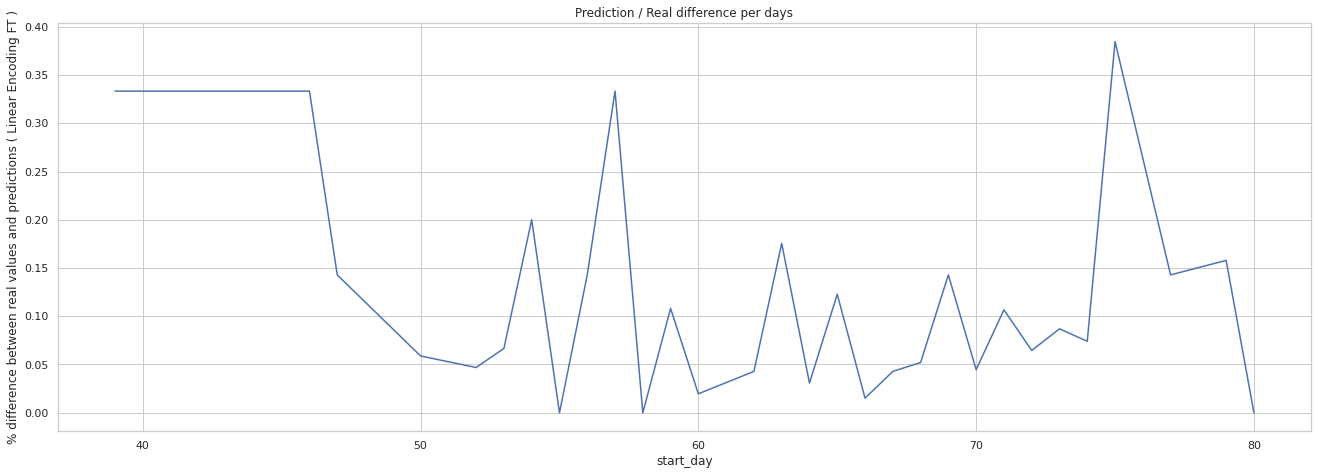

In [98]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

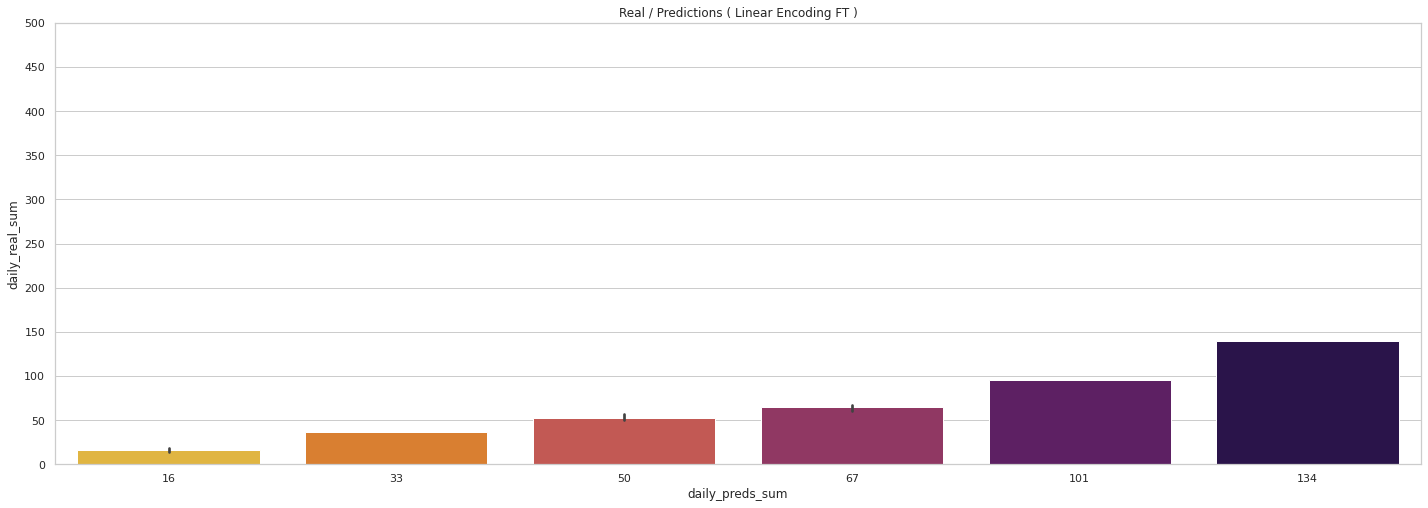

In [99]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

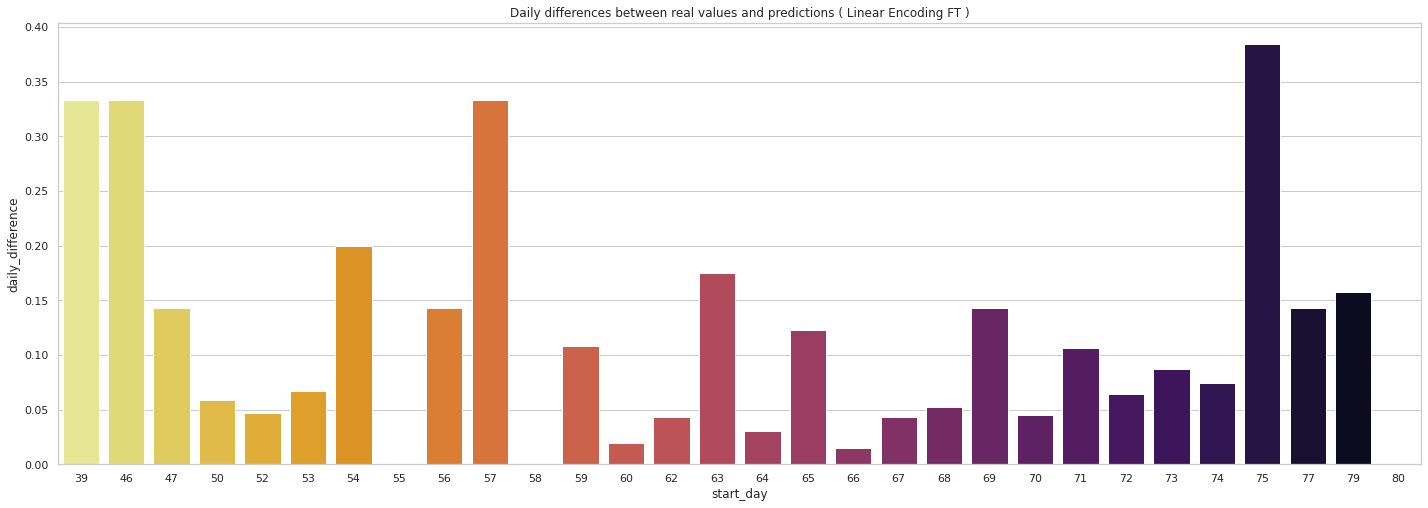

In [100]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### LightGBM

In [101]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
df = data.copy()
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

In [102]:

### Train & Validation 
from sklearn.model_selection import train_test_split
FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES]
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

3.0619454865267928

In [103]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)


lgb_r2

0.25774946052849657

In [106]:
### Parameter Optimization
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
param_comb = 6

kf = StratifiedKFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
print(random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'reg_lambda': 1, 'num_leaves': 16, 'num_iterations': 500, 'min_child_weight': 10, 'max_depth': 4, 'colsample_bytree': 0.5}


In [107]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2
##Test
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)[FEATURES])
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)

In [109]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions')

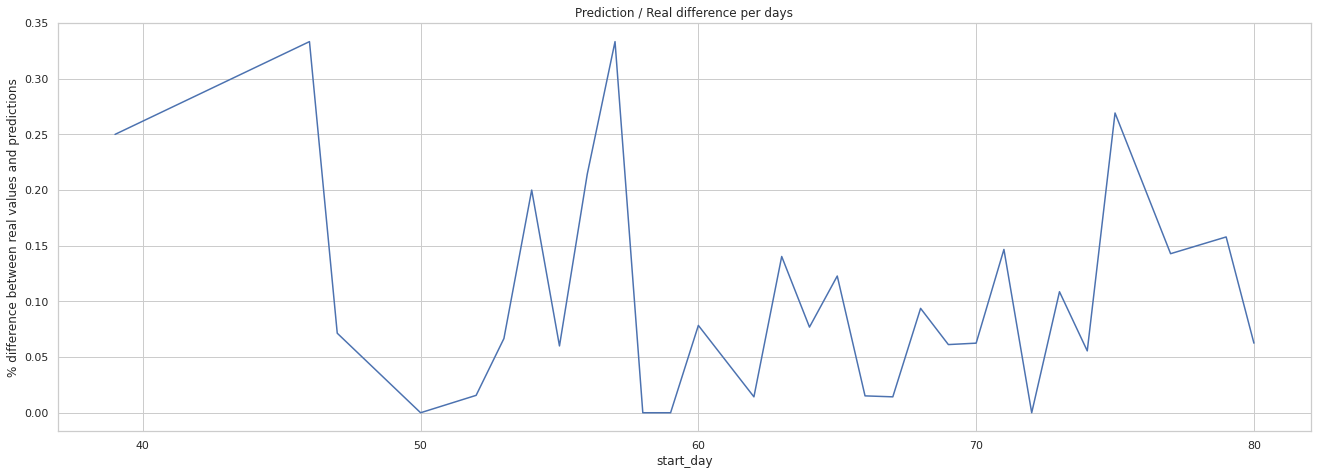

In [110]:
test["preds"] = a.preds.values
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

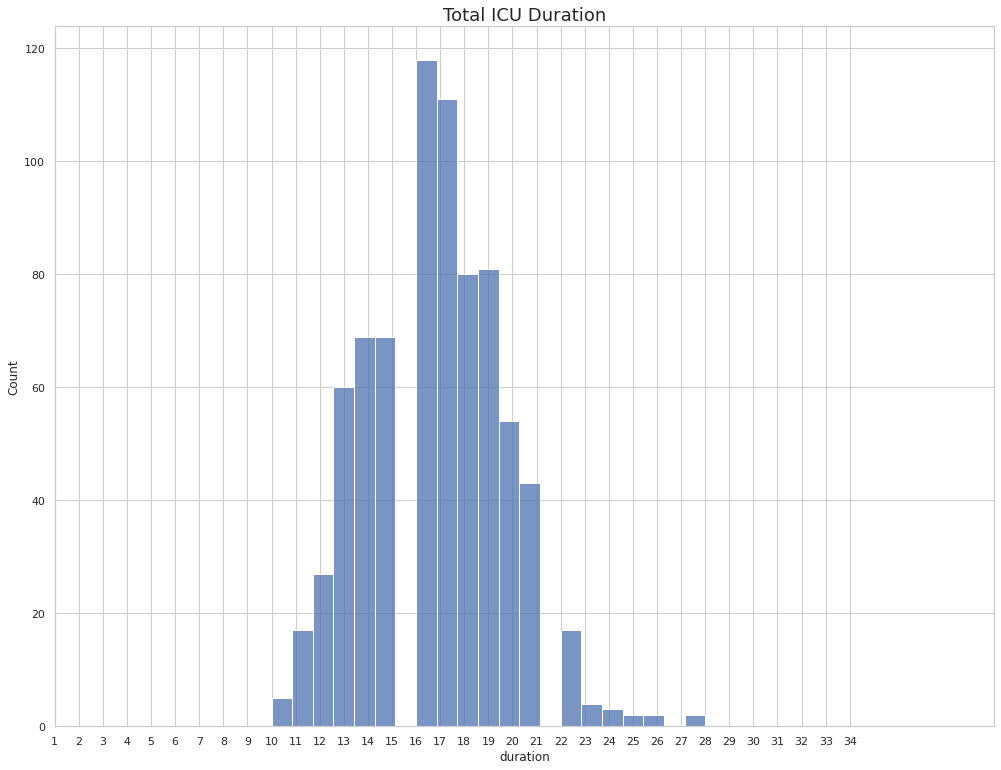

In [111]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,35,1))
plt.xlim(1,40)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

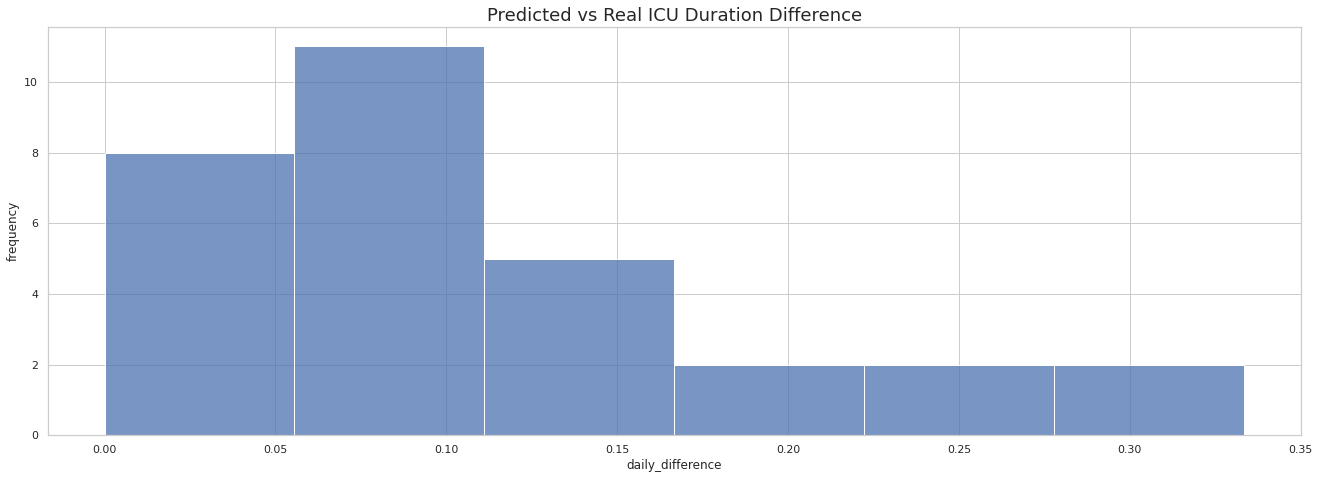

In [112]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

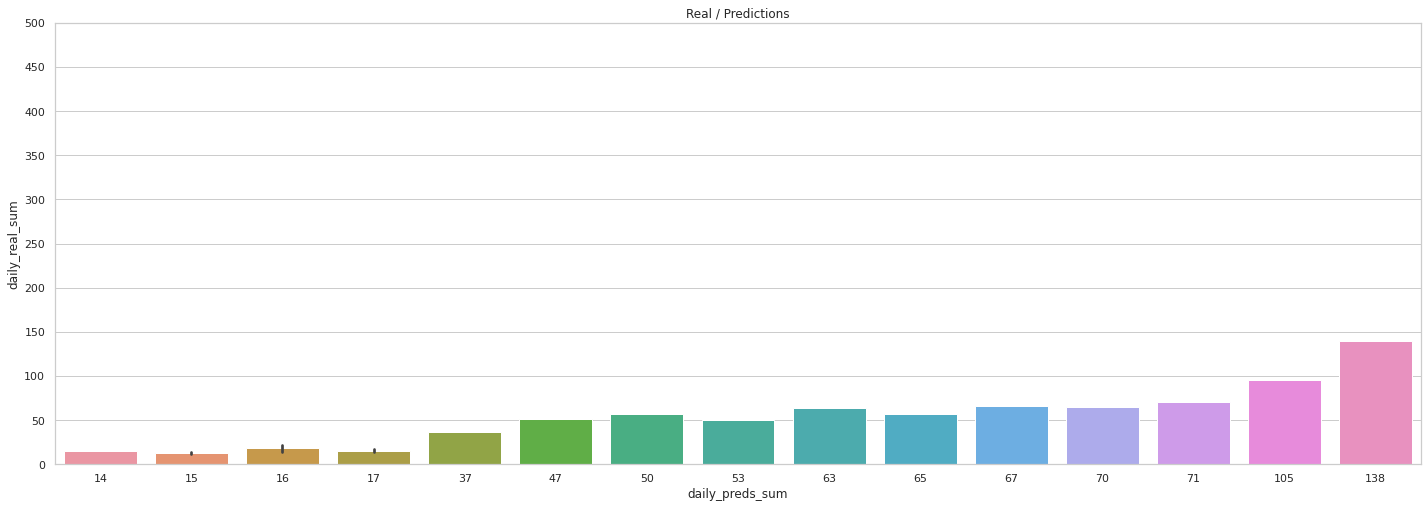

In [113]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions')

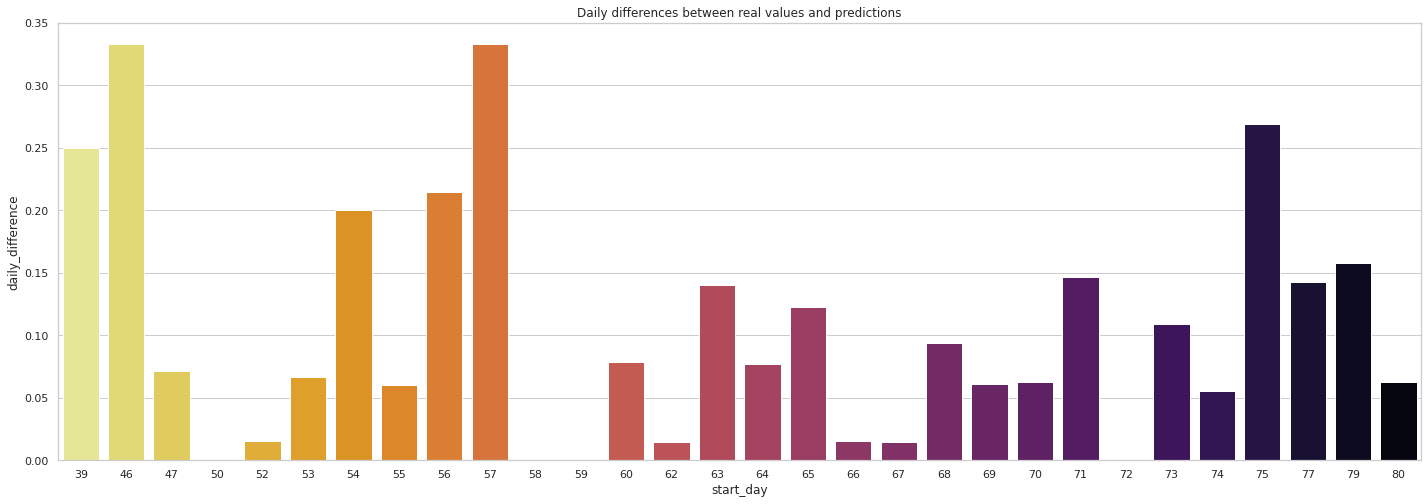

In [114]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

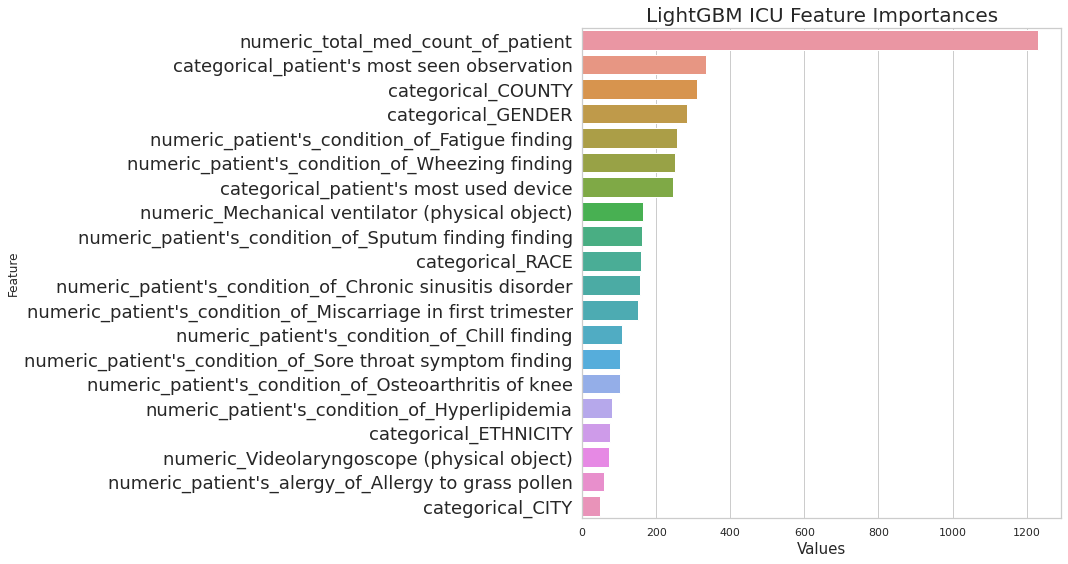

<Figure size 432x288 with 0 Axes>

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 8))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

### Our results were like this :

In [116]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-0.024296,2.593303,3.299549
Transformer - Periodic Encoding,-0.024296,2.572751,3.273774
LightGBM,0.257749,2.175440,2.808777


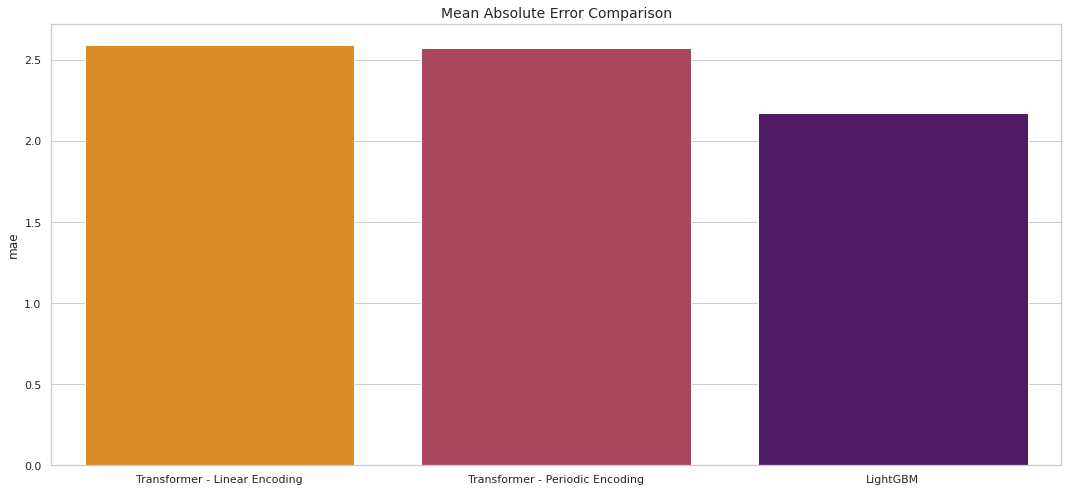

In [117]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


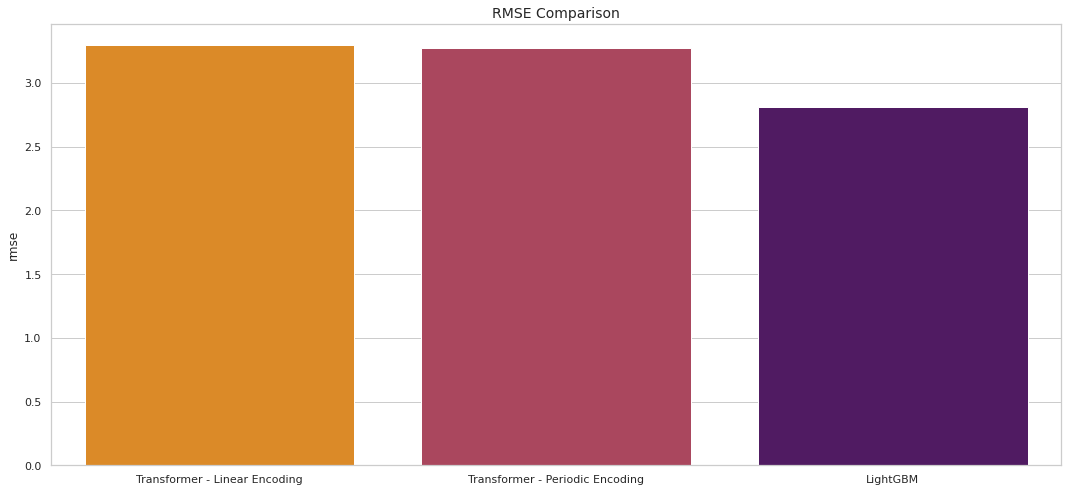

In [118]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


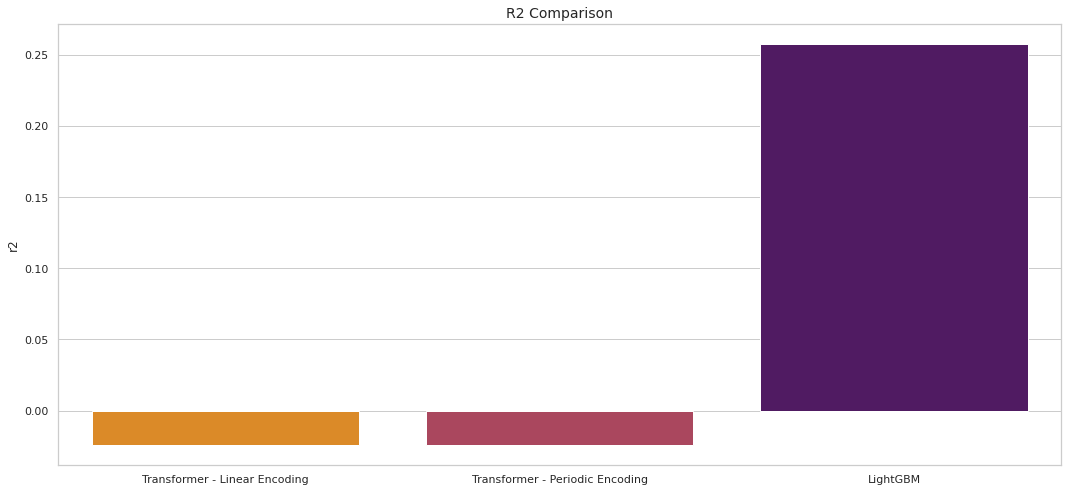

In [119]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [120]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.000676,2.551832,3.261285
Transformer - Periodic Encoding TUNED,-0.000649,2.557927,3.261240
LightGBM TUNED,0.262296,2.175894,2.800161


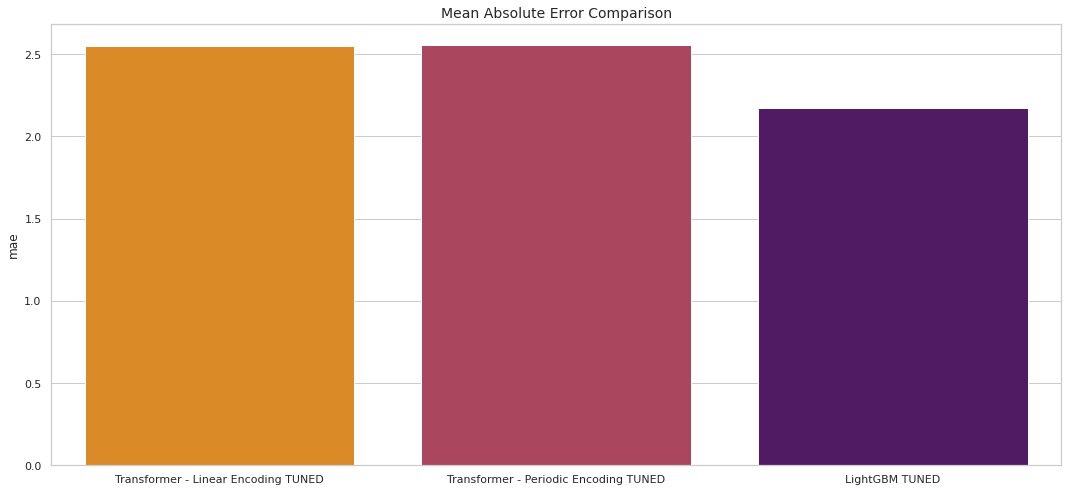

In [121]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


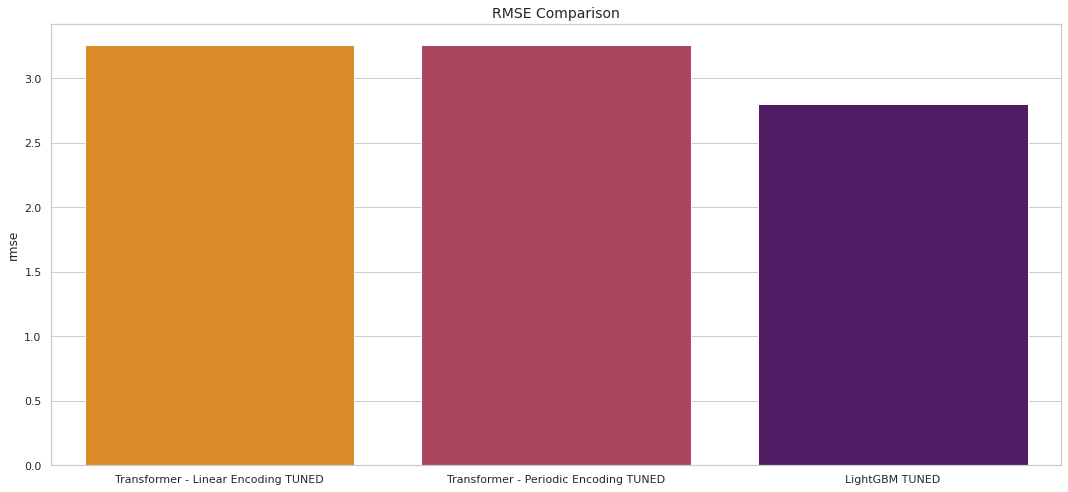

In [122]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


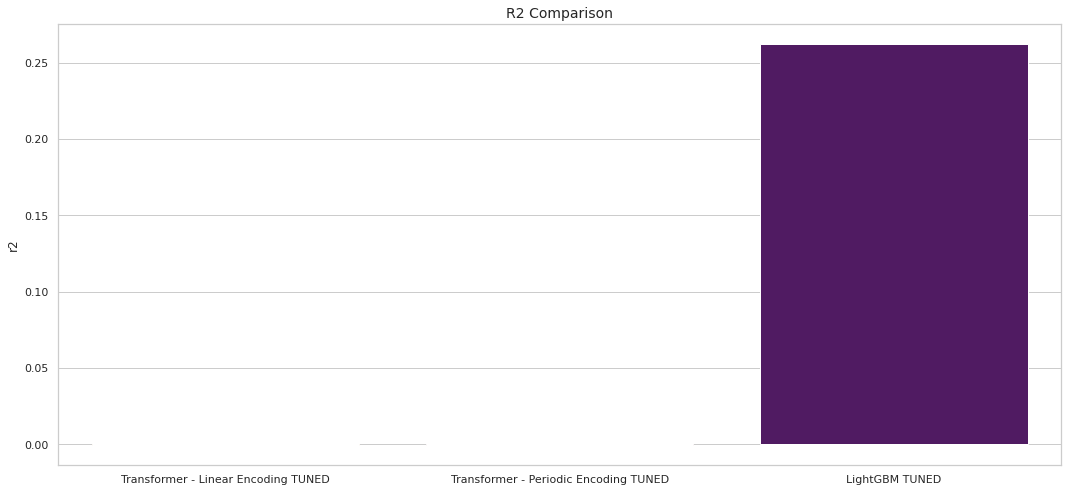

In [123]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
